In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
from sklearn.metrics import confusion_matrix
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [3]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
list_of_file_names_org = list_of_file_names

In [4]:
fail_list

[3]

In [5]:
for x in fail_list:
    del list_of_file_names[x]

In [6]:
list_of_file_names[23]

'./zip_2/Zip_MedianListingPricePerSqft_AllHomes.csv'

In [7]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [8]:
useful_df = build_useful_df(read_data_list_2)


In [9]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [10]:
len(sixteen_list)

30

In [11]:
good_columns = []
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)

In [12]:
sixteen_good = []
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [13]:
len(sixteen_good)

12

In [14]:
target_data = useful_df[23]

In [15]:
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [16]:
len(final_data_list[3])

10066

In [17]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
#useful_df[0].head(50)

In [18]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    return features
    

def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    

    
    return df_one, target




test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)







date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

#### w2v features

In [19]:
w2v_features = pd.read_csv('real_business_w2v_features_3_6')

In [20]:
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)

In [21]:
w2v_features.shape

(951, 512)

In [22]:
w2v_features.index = w2v_features['postal_code']

In [23]:
w2v_features = w2v_features.iloc[:, 1:]

#### Business features

In [25]:
business_features = pd.read_csv('real_business_features_3_4')

In [26]:
business_features.shape

(959, 11)

In [27]:
business_features['postal_code'] = business_features['postal_code'].astype(str)

In [28]:
business_features = business_features.set_index('postal_code')

#### Adjusting train test sets

In [31]:
train_features = train_features.reset_index()

In [32]:
test_features = test_features.reset_index()

In [33]:
train_targets = train_targets.reset_index()

In [34]:
test_targets = test_targets.reset_index()

In [35]:
# Merging on index for train features and targets so it doesn't multiply 
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')

In [36]:
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')

In [37]:
train_merge = train_merge.set_index('RegionName_x')

In [38]:
test_merge = test_merge.set_index('RegionName_x')

In [42]:
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [43]:
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [44]:
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [45]:
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [46]:
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [47]:
nztmc = new_zillow_test_merge.columns
test_merge = new_zillow_test_merge.iloc[:, :-10]

In [48]:
new_zillow_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [49]:
train_merge = new_zillow_train_merge.iloc[:, :-10]

In [50]:
train_merge = train_merge.drop('RegionName_y', 1)

In [51]:
test_merge = test_merge.drop('RegionName_y', 1)

In [52]:
train_merge.dropna(inplace=True)

In [53]:
test_merge.dropna(inplace=True)

In [54]:
business_train_merge.dropna(inplace=True)

In [55]:
business_test_merge.dropna(inplace=True)

In [56]:
w2v_train_merge.dropna(inplace=True)

In [57]:
w2v_test_merge.dropna(inplace=True)

#### Creating arrays and train test splits

In [60]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

In [61]:
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

In [62]:
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

#### Normalizing the arrays

In [63]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [64]:
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)

In [65]:
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)

In [66]:
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

In [67]:
y_test.var()

0.0028560998107322942

In [68]:
print(y_train.mean())
print(y_train.min())
print(y_train.max())

1.03568676443
0.809566962437
1.32300764356


In [69]:
print(y_test.mean())
print(y_test.min())
print(y_test.max())

1.01812630226
0.833675690212
1.18704258259


#### Creating classes for targets

In [70]:
def create_y_class_2(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    
    for y in y_list:
        if y <= .9:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .9 and y <= .97:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .97 and y < 1.03:
            y_3.append(1)
        else:
            y_3.append(0)
        if y >= 1.03 and y < 1.1:
            y_4.append(1)
        else:
            y_4.append(0)
        if y >= 1.1:
            y_5.append(1)
        else:
            y_5.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    return y_df

In [71]:
y_cat_train = create_y_class_2(y_train)

In [72]:
y_cat_test = create_y_class_2(y_test)

In [73]:
y_cat_train_w2v = create_y_class_2(y_train_w2v)

In [74]:
y_cat_test_w2v = create_y_class_2(y_test_w2v)

In [75]:
y_cat_train_business = create_y_class_2(y_train_business)

In [76]:
y_cat_test_business = create_y_class_2(y_test_business)

In [77]:
y_test_business.var()

0.0028560998107322942

In [738]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [739]:
model.fit(x=X_train, y=y_train, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 2.4648 - val_loss: 1.7106
Epoch 2/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.2855 - val_loss: 0.1537
Epoch 3/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.3109 - val_loss: 0.1096
Epoch 4/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.2574 - val_loss: 0.1539
Epoch 5/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.2579 - val_loss: 0.1283
Epoch 6/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.2167 - val_loss: 0.0970
Epoch 7/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.1962 - val_loss: 0.1111
Epoch 8/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.1968 - val_loss: 0.1375
Epoch 9/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.1932 - val_loss: 0.1611
Epoch 10/500
2839/

2839/2839 [==============================] - 0s 30us/step - loss: 0.0065 - val_loss: 0.0029
Epoch 156/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0063 - val_loss: 0.0027
Epoch 157/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0054 - val_loss: 0.0027
Epoch 158/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0051 - val_loss: 0.0027
Epoch 159/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0060 - val_loss: 0.0033
Epoch 160/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 161/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 162/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0049 - val_loss: 0.0028
Epoch 163/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0053 - val_loss: 0.0027
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0053
Epoch 310/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0056
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 312/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0017 - val_loss: 0.0052
Epoch 313/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0018 - val_loss: 0.0070
Epoch 314/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0055
Epoch 315/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0057
Epoch 316/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0017 - val_loss: 0.0059
Epoch 317/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0060
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0057
Epoch 464/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0047
Epoch 465/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0054
Epoch 466/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0069
Epoch 467/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 468/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 469/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0053
Epoch 470/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0080
Epoch 471/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 472/500
2839/2839 [==============================] - 0

In [ ]:
plt.plot(zillow_model.history['loss'])
plt.plot(zillow_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [740]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [743]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0043
Epoch 2/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0055 - val_loss: 0.0088
Epoch 3/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0137 - val_loss: 0.0133
Epoch 4/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0160 - val_loss: 0.0030
Epoch 5/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 6/500
2839/2839 [==============================] - 0s 41us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 9/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/500
2839

2839/2839 [==============================] - 0s 29us/step - loss: 0.1538 - val_loss: 0.2634
Epoch 156/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.2671 - val_loss: 0.2698
Epoch 157/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.2900 - val_loss: 0.8574
Epoch 158/500
2839/2839 [==============================] - 0s 32us/step - loss: 4.1008 - val_loss: 30.9265
Epoch 159/500
2839/2839 [==============================] - 0s 30us/step - loss: 37.3535 - val_loss: 24.0820
Epoch 160/500
2839/2839 [==============================] - 0s 30us/step - loss: 18.2658 - val_loss: 0.0029
Epoch 161/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0098 - val_loss: 0.0029
Epoch 162/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0082 - val_loss: 0.0029
Epoch 163/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0070 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================]

2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 310/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 312/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 313/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 314/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 315/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 316/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 317/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 35us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 464/500
2839/2839 [==============================] - 0s 49us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 465/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 466/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 467/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 468/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 469/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 470/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0047
Epoch 471/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0074 - val_loss: 0.0031
Epoch 472/500
2839/2839 [==============================] - 0

In [745]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [746]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 3.1253 - val_loss: 0.3215
Epoch 2/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.3927 - val_loss: 0.2637
Epoch 3/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.3240 - val_loss: 0.2399
Epoch 4/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2909 - val_loss: 0.1291
Epoch 5/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2447 - val_loss: 0.1072
Epoch 6/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.2297 - val_loss: 0.1186
Epoch 7/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2025 - val_loss: 0.2005
Epoch 8/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.2366 - val_loss: 0.2338
Epoch 9/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.2277 - val_loss: 0.1693
Epoch 10/500
2839/

2839/2839 [==============================] - 0s 74us/step - loss: 0.0199 - val_loss: 0.0030
Epoch 156/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0184 - val_loss: 0.0029
Epoch 157/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0193 - val_loss: 0.0029
Epoch 158/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0183 - val_loss: 0.0029
Epoch 159/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0184 - val_loss: 0.0027
Epoch 160/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0198 - val_loss: 0.0031
Epoch 161/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.0197 - val_loss: 0.0031
Epoch 162/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0185 - val_loss: 0.0030
Epoch 163/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0189 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 78us/step - loss: 0.0067 - val_loss: 0.0026
Epoch 310/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0028
Epoch 311/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0067 - val_loss: 0.0027
Epoch 312/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0025
Epoch 313/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0063 - val_loss: 0.0027
Epoch 314/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0068 - val_loss: 0.0028
Epoch 315/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 316/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 317/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0063 - val_loss: 0.0031
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 73us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 464/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 465/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 466/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 467/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 468/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 469/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 470/500
2839/2839 [==============================] - 0s 83us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 471/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 472/500
2839/2839 [==============================] - 0

#### Switched top 10% below (will notate where) to 15%. The only instance where it has changed is in the weighted w2v model cell.
#### This is where we generate the metrics

In [85]:
def model_metrics(predictions, y_test):
    df = pd.DataFrame(predictions)
    predicted_classes = predictions.argmax(axis=1)
    # predicting a loss 3% or larger by seeing if max loss probability is higher then slight gain
    df['loss'] = np.where(df[0] > df[3], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then slight loss
    df['gain'] = np.where(df[4] > df[1], 1, 0)
    df = pd.merge(df, y_test, left_index=True, right_index=True, how='inner')
    # predicting a loss 3% or larger by seeing if max loss probability is higher then mean probibility 
    df['loss_large'] = np.where(df[0] > df[2], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then mean probibility 
    df['gain_large'] = np.where(df[4] > df[2], 1, 0)
    # Cheching if loss is predicted and a loss of 3% or more occurs
    df['loss_true_true'] = np.where((df['loss'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Checking if loss is predicted and price stays at the mean
    df['loss_stay'] = np.where((df['loss'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large loss is predicted and a loss of 3% or more occurs
    df['loss_large_true'] = np.where((df['loss_large'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Cheching if large loss is predicted and price stays at the mean
    df['loss_large_stay'] = np.where((df['loss_large'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if gain is predicted and a loss of 3% or more occurs
    df['gain_true_true'] = np.where((df['gain'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Checking if gain is predicted and price stays at the mean
    df['gain_stay'] = np.where((df['gain'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large gain is predicted and a gain of 3% or more occurs
    df['gain_large_true'] = np.where((df['gain_large'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Cheching if large gain is predicted and price stays at the mean
    df['gain_large_stay'] = np.where((df['gain_large'] == 1) & (df['3'] == 1), 1, 0)
    #df['gain_large_large'] = np.where((df['gain_large'] == 1) & (df['5'] == 1), 1, 0)
    # Checking if both loss and gain are selected. This appears to mean high volitility
    df['volitile'] = np.where((df['loss'] == 1) & (df['gain'] == 1), 1, 0)
    df['top_vs_mean_low'] = (df[4] + df[3]) - (df[2] + df[1])
    df = df.sort_values('top_vs_mean_low', ascending=False)
    top_10 = []
    # Here is where I switched 10% to 15%
    top = round(len(df) * .15)
    for num in range(top):
        top_10.append(1)
    finish_list = len(df) - len(top_10)
    for num in range(finish_list):
        top_10.append(0)
    df['top_vs_mean_low_select'] = top_10
    df['top_vs_mean_low_select_true'] = np.where((df['top_vs_mean_low_select'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['top_vs_mean_low_select_large'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['5'] == 1), 1, 0)
    df['gain_large_true_large'] = np.where((df['gain'] == 1) & (df['5'] == 1), 1, 0)
    df['top_vs_mean_low_select_mean'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['3'] == 1), 1, 0)
    df['predicted_classes'] = predicted_classes
    df['predicted_classes_gain'] = np.where((df['predicted_classes'] == 3) | (df['predicted_classes'] == 4) , 1, 0)
    df['predicted_classes_gain_true'] = np.where((df['predicted_classes_gain'] == 1)  & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['predicted_classes_gain_large_true'] = np.where((df['predicted_classes_gain'] == 1) & (df['5'] == 1), 1, 0)
    df['predicted_classes_gain_mean'] = np.where((df['predicted_classes_gain'] == 1) & (df['3'] == 1), 1, 0)
    
    
    
    gain_pred = df['gain'].sum()
    gain_large_pred = df['gain_large'].sum()
    
    gain_stay_true = (df['gain_true_true'].sum() + df['gain_stay'].sum()) / df['gain'].sum()
    
    #top_vs_mid = 
    gain_true = df['gain_true_true'].sum() / df['gain'].sum()
    #loss_stay_true = (df['loss_true_true'].sum() + df['loss_stay'].sum()) / df['loss'].sum()
    #loss_stay_true = df['loss_true_true'].sum() / df['loss'].sum()
    gain_stay_large_true = (df['gain_large_true'].sum() + df['gain_large_stay'].sum()) / df['gain_large'].sum()
    gain_large_true = df['gain_large_true'].sum() / df['gain_large'].sum()
    #loss_stay_large_true = (df['loss_large_true'].sum() + df['loss_large_stay']) / df['loss_large'].sum()
    #loss_large_true = df['loss_large_true'].sum() / df['loss_large'].sum()
    volitile = df['volitile'].sum()
    four_five_split = df['top_vs_mean_low_select_true'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_large = df['top_vs_mean_low_select_large'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_mean = (df['top_vs_mean_low_select_true'].sum() + df['top_vs_mean_low_select_mean'].sum()) / df['top_vs_mean_low_select'].sum()
    predicted_classes_gain_true = df['predicted_classes_gain_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_large_true = df['predicted_classes_gain_large_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_mean = (df['predicted_classes_gain_true'].sum() + df['predicted_classes_gain_mean'].sum()) / df['predicted_classes_gain'].sum()
    gain_true_large = df['gain_large_true_large'].sum() / df['gain'].sum()
    #print(gain_pred)
    #print(gain_true)
    #print(gain_stay_true)
    #print(gain_large_pred)
    #print(gain_large_true)
    #print(gain_stay_large_true)
    #print(four_five_split)
    #print(gain_large_true_large)
    return gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean 
    

In [1114]:
predicted_classes = predictions.argmax(axis=1)
predicted_classes

array([4, 3, 3, 4, 1, 2, 4, 4, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4,
       2, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 4, 1, 3, 1, 3, 0,
       3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3,
       3, 4, 1, 4, 1, 1, 1, 3, 1, 4, 4, 3, 3, 4, 2, 0, 4, 0, 3, 4, 0, 4, 1,
       3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 4, 3, 3, 3, 2, 2, 3, 3, 2, 3, 1, 3, 3,
       3, 2, 3, 0, 1, 2, 4, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 1,
       2, 2, 3, 2, 4, 2, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 2, 3, 3, 1, 4, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 3, 1,
       1, 3,

In [780]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [781]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 6s 2ms/step - loss: 1.6362 - acc: 0.1786 - val_loss: 1.6403 - val_acc: 0.0785
Epoch 2/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.6369 - acc: 0.1803 - val_loss: 1.6390 - val_acc: 0.0785
Epoch 3/500
2839/2839 [==============================] - 0s 30us/step - loss: 1.6321 - acc: 0.1923 - val_loss: 1.6380 - val_acc: 0.0785
Epoch 4/500
2839/2839 [==============================] - 0s 32us/step - loss: 1.6380 - acc: 0.1934 - val_loss: 1.6370 - val_acc: 0.0816
Epoch 5/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.6394 - acc: 0.1789 - val_loss: 1.6361 - val_acc: 0.0846
Epoch 6/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.6386 - acc: 0.1744 - val_loss: 1.6353 - val_acc: 0.0876
Epoch 7/500
2839/2839 [==============================] - 0s 35us/step - loss: 1.6299 - acc: 0.1934 - val_loss: 1.6344 - val_acc: 0.0906
Ep

Epoch 61/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.5978 - acc: 0.2145 - val_loss: 1.6019 - val_acc: 0.2538
Epoch 62/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5990 - acc: 0.2219 - val_loss: 1.6014 - val_acc: 0.2508
Epoch 63/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.6002 - acc: 0.2321 - val_loss: 1.6008 - val_acc: 0.2477
Epoch 64/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5976 - acc: 0.2230 - val_loss: 1.6003 - val_acc: 0.2538
Epoch 65/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.6062 - acc: 0.2135 - val_loss: 1.5998 - val_acc: 0.2568
Epoch 66/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.5947 - acc: 0.2318 - val_loss: 1.5992 - val_acc: 0.2568
Epoch 67/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.5976 - acc: 0.2342 - val_loss: 1.5987 - val_acc: 0.2568
Epoch 68/500
2839/2839 [=================

Epoch 121/500
2839/2839 [==============================] - 0s 30us/step - loss: 1.5725 - acc: 0.2652 - val_loss: 1.5718 - val_acc: 0.3293
Epoch 122/500
2839/2839 [==============================] - 0s 36us/step - loss: 1.5681 - acc: 0.2571 - val_loss: 1.5713 - val_acc: 0.3384
Epoch 123/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.5677 - acc: 0.2635 - val_loss: 1.5708 - val_acc: 0.3384
Epoch 124/500
2839/2839 [==============================] - 0s 35us/step - loss: 1.5636 - acc: 0.2603 - val_loss: 1.5702 - val_acc: 0.3384
Epoch 125/500
2839/2839 [==============================] - 0s 37us/step - loss: 1.5601 - acc: 0.2730 - val_loss: 1.5697 - val_acc: 0.3353
Epoch 126/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.5672 - acc: 0.2642 - val_loss: 1.5692 - val_acc: 0.3353
Epoch 127/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5657 - acc: 0.2557 - val_loss: 1.5687 - val_acc: 0.3384
Epoch 128/500
2839/2839 [=========

Epoch 181/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5356 - acc: 0.2994 - val_loss: 1.5408 - val_acc: 0.3656
Epoch 182/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5517 - acc: 0.2969 - val_loss: 1.5403 - val_acc: 0.3656
Epoch 183/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.5369 - acc: 0.2853 - val_loss: 1.5398 - val_acc: 0.3686
Epoch 184/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5356 - acc: 0.3086 - val_loss: 1.5393 - val_acc: 0.3686
Epoch 185/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5377 - acc: 0.3015 - val_loss: 1.5387 - val_acc: 0.3686
Epoch 186/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5384 - acc: 0.2976 - val_loss: 1.5383 - val_acc: 0.3746
Epoch 187/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5325 - acc: 0.2998 - val_loss: 1.5377 - val_acc: 0.3746
Epoch 188/500
2839/2839 [=========

Epoch 241/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5123 - acc: 0.3241 - val_loss: 1.5110 - val_acc: 0.3807
Epoch 242/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5136 - acc: 0.3286 - val_loss: 1.5105 - val_acc: 0.3776
Epoch 243/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5186 - acc: 0.3219 - val_loss: 1.5101 - val_acc: 0.3776
Epoch 244/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5087 - acc: 0.3315 - val_loss: 1.5096 - val_acc: 0.3807
Epoch 245/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.5089 - acc: 0.3318 - val_loss: 1.5091 - val_acc: 0.3807
Epoch 246/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5147 - acc: 0.3300 - val_loss: 1.5087 - val_acc: 0.3837
Epoch 247/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.5095 - acc: 0.3269 - val_loss: 1.5081 - val_acc: 0.3807
Epoch 248/500
2839/2839 [=========

Epoch 301/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4929 - acc: 0.3484 - val_loss: 1.4831 - val_acc: 0.3595
Epoch 302/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.4878 - acc: 0.3561 - val_loss: 1.4826 - val_acc: 0.3595
Epoch 303/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4979 - acc: 0.3237 - val_loss: 1.4822 - val_acc: 0.3595
Epoch 304/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4855 - acc: 0.3452 - val_loss: 1.4817 - val_acc: 0.3565
Epoch 305/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4936 - acc: 0.3237 - val_loss: 1.4812 - val_acc: 0.3595
Epoch 306/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.5012 - acc: 0.3272 - val_loss: 1.4808 - val_acc: 0.3595
Epoch 307/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4754 - acc: 0.3512 - val_loss: 1.4803 - val_acc: 0.3595
Epoch 308/500
2839/2839 [=========

Epoch 361/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4755 - acc: 0.3470 - val_loss: 1.4577 - val_acc: 0.3474
Epoch 362/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4680 - acc: 0.3667 - val_loss: 1.4573 - val_acc: 0.3474
Epoch 363/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4590 - acc: 0.3575 - val_loss: 1.4569 - val_acc: 0.3474
Epoch 364/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4571 - acc: 0.3751 - val_loss: 1.4565 - val_acc: 0.3474
Epoch 365/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4699 - acc: 0.3551 - val_loss: 1.4562 - val_acc: 0.3474
Epoch 366/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4682 - acc: 0.3512 - val_loss: 1.4558 - val_acc: 0.3474
Epoch 367/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4567 - acc: 0.3663 - val_loss: 1.4554 - val_acc: 0.3474
Epoch 368/500
2839/2839 [=========

Epoch 421/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.4590 - acc: 0.3519 - val_loss: 1.4352 - val_acc: 0.3414
Epoch 422/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.4610 - acc: 0.3695 - val_loss: 1.4348 - val_acc: 0.3444
Epoch 423/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4471 - acc: 0.3751 - val_loss: 1.4345 - val_acc: 0.3444
Epoch 424/500
2839/2839 [==============================] - 0s 32us/step - loss: 1.4553 - acc: 0.3737 - val_loss: 1.4342 - val_acc: 0.3444
Epoch 425/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.4447 - acc: 0.3625 - val_loss: 1.4339 - val_acc: 0.3444
Epoch 426/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4451 - acc: 0.3734 - val_loss: 1.4335 - val_acc: 0.3444
Epoch 427/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4416 - acc: 0.3681 - val_loss: 1.4331 - val_acc: 0.3444
Epoch 428/500
2839/2839 [=========

Epoch 481/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4309 - acc: 0.3765 - val_loss: 1.4163 - val_acc: 0.3444
Epoch 482/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.4394 - acc: 0.3607 - val_loss: 1.4160 - val_acc: 0.3444
Epoch 483/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.4350 - acc: 0.3737 - val_loss: 1.4156 - val_acc: 0.3444
Epoch 484/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.4573 - acc: 0.3610 - val_loss: 1.4154 - val_acc: 0.3444
Epoch 485/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4372 - acc: 0.3656 - val_loss: 1.4150 - val_acc: 0.3444
Epoch 486/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.4246 - acc: 0.3861 - val_loss: 1.4147 - val_acc: 0.3444
Epoch 487/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.4316 - acc: 0.3769 - val_loss: 1.4144 - val_acc: 0.3444
Epoch 488/500
2839/2839 [=========

In [782]:
predictions = model.predict(X_test)
model_metrics(predictions, y_cat_test)

ZeroDivisionError: division by zero

In [783]:
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  1,   8,  16,  13,   0],
       [  4,  44, 128,  97,  20],
       [  0,   0,   0,   0,   0]])

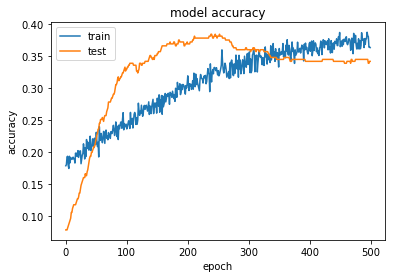

In [784]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [785]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [786]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=500, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 2ms/step - loss: 1.5033 - acc: 0.3716 - val_loss: 1.3798 - val_acc: 0.3323
Epoch 2/500
2839/2839 [==============================] - 0s 38us/step - loss: 1.3634 - acc: 0.3853 - val_loss: 1.3100 - val_acc: 0.3444
Epoch 3/500
2839/2839 [==============================] - 0s 38us/step - loss: 1.3411 - acc: 0.4181 - val_loss: 1.3122 - val_acc: 0.3293
Epoch 4/500
2839/2839 [==============================] - 0s 38us/step - loss: 1.3114 - acc: 0.4068 - val_loss: 1.3019 - val_acc: 0.4079
Epoch 5/500
2839/2839 [==============================] - 0s 39us/step - loss: 1.3128 - acc: 0.4086 - val_loss: 1.2902 - val_acc: 0.3414
Epoch 6/500
2839/2839 [==============================] - 0s 38us/step - loss: 1.3031 - acc: 0.4001 - val_loss: 1.2780 - val_acc: 0.3565
Epoch 7/500
2839/2839 [==============================] - 0s 37us/step - loss: 1.2880 - acc: 0.4178 - val_loss: 1.2635 - val_acc: 0.4773
Ep

2839/2839 [==============================] - 0s 40us/step - loss: 0.7938 - acc: 0.6375 - val_loss: 1.3074 - val_acc: 0.5257
Epoch 120/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.8180 - acc: 0.6323 - val_loss: 1.2888 - val_acc: 0.4955
Epoch 121/500
2839/2839 [==============================] - 0s 37us/step - loss: 0.7835 - acc: 0.6552 - val_loss: 1.2142 - val_acc: 0.5468
Epoch 122/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.7940 - acc: 0.6562 - val_loss: 1.2368 - val_acc: 0.5317
Epoch 123/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.8201 - acc: 0.6323 - val_loss: 1.2557 - val_acc: 0.5257
Epoch 124/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.7745 - acc: 0.6622 - val_loss: 1.2163 - val_acc: 0.5589
Epoch 125/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.7715 - acc: 0.6640 - val_loss: 1.2688 - val_acc: 0.5408
Epoch 126/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 36us/step - loss: 0.5134 - acc: 0.7869 - val_loss: 1.7977 - val_acc: 0.5015
Epoch 238/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.5274 - acc: 0.7841 - val_loss: 1.7531 - val_acc: 0.4924
Epoch 239/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.6088 - acc: 0.7369 - val_loss: 1.8138 - val_acc: 0.4773
Epoch 240/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.5263 - acc: 0.7834 - val_loss: 1.8974 - val_acc: 0.4804
Epoch 241/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.5723 - acc: 0.7640 - val_loss: 1.8715 - val_acc: 0.4864
Epoch 242/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.5331 - acc: 0.7795 - val_loss: 1.8751 - val_acc: 0.4683
Epoch 243/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.5346 - acc: 0.7770 - val_loss: 1.7585 - val_acc: 0.5045
Epoch 244/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 37us/step - loss: 0.3955 - acc: 0.8475 - val_loss: 2.4165 - val_acc: 0.4381
Epoch 356/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.3721 - acc: 0.8492 - val_loss: 2.1627 - val_acc: 0.4622
Epoch 357/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.4189 - acc: 0.8330 - val_loss: 2.3412 - val_acc: 0.4834
Epoch 358/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.4018 - acc: 0.8408 - val_loss: 2.3807 - val_acc: 0.4653
Epoch 359/500
2839/2839 [==============================] - 0s 37us/step - loss: 0.4106 - acc: 0.8362 - val_loss: 2.2662 - val_acc: 0.4894
Epoch 360/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.4236 - acc: 0.8302 - val_loss: 2.4143 - val_acc: 0.4592
Epoch 361/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.3619 - acc: 0.8570 - val_loss: 2.4279 - val_acc: 0.4411
Epoch 362/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 40us/step - loss: 0.3234 - acc: 0.8753 - val_loss: 3.0210 - val_acc: 0.4804
Epoch 474/500
2839/2839 [==============================] - 0s 40us/step - loss: 0.3418 - acc: 0.8672 - val_loss: 2.8961 - val_acc: 0.4713
Epoch 475/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.2836 - acc: 0.8926 - val_loss: 3.0902 - val_acc: 0.4773
Epoch 476/500
2839/2839 [==============================] - 0s 38us/step - loss: 0.3010 - acc: 0.8834 - val_loss: 3.1999 - val_acc: 0.4622
Epoch 477/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.3515 - acc: 0.8591 - val_loss: 3.1376 - val_acc: 0.4713
Epoch 478/500
2839/2839 [==============================] - 0s 37us/step - loss: 0.3106 - acc: 0.8788 - val_loss: 2.5768 - val_acc: 0.5136
Epoch 479/500
2839/2839 [==============================] - 0s 37us/step - loss: 0.3260 - acc: 0.8672 - val_loss: 2.7457 - val_acc: 0.4924
Epoch 480/500
2839/2839 [=======================

In [787]:
predictions = model.predict(X_test_business)
model_metrics(predictions, y_cat_test_business)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test_business.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

75
0.6933333333333334
0.9466666666666667
26
0.6538461538461539
0.8846153846153846


array([[  0,   0,   0,   0,   0],
       [  4,  32,  30,   8,   4],
       [  1,  16, 100,  76,   5],
       [  0,   2,  11,  18,   7],
       [  0,   2,   3,   8,   4]])

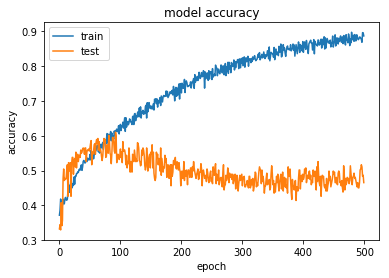

In [788]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [789]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [790]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=500, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 5s 2ms/step - loss: 1.5258 - acc: 0.3364 - val_loss: 1.4371 - val_acc: 0.4109
Epoch 2/500
2839/2839 [==============================] - 0s 75us/step - loss: 1.3853 - acc: 0.3913 - val_loss: 1.3264 - val_acc: 0.3505
Epoch 3/500
2839/2839 [==============================] - 0s 79us/step - loss: 1.3349 - acc: 0.4089 - val_loss: 1.2662 - val_acc: 0.3686
Epoch 4/500
2839/2839 [==============================] - 0s 88us/step - loss: 1.3340 - acc: 0.4015 - val_loss: 1.2256 - val_acc: 0.4834
Epoch 5/500
2839/2839 [==============================] - 0s 74us/step - loss: 1.3127 - acc: 0.3959 - val_loss: 1.2376 - val_acc: 0.4622
Epoch 6/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.3010 - acc: 0.3998 - val_loss: 1.2260 - val_acc: 0.4441
Epoch 7/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.2891 - acc: 0.3984 - val_loss: 1.2199 - val_acc: 0.4471
Ep

Epoch 120/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.8703 - acc: 0.6150 - val_loss: 1.1655 - val_acc: 0.5166
Epoch 121/500
2839/2839 [==============================] - 0s 86us/step - loss: 0.9008 - acc: 0.5738 - val_loss: 1.1591 - val_acc: 0.4864
Epoch 122/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.8980 - acc: 0.6069 - val_loss: 1.1493 - val_acc: 0.5257
Epoch 123/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.8798 - acc: 0.6122 - val_loss: 1.1784 - val_acc: 0.4804
Epoch 124/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.8743 - acc: 0.6178 - val_loss: 1.1536 - val_acc: 0.5287
Epoch 125/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.8883 - acc: 0.6013 - val_loss: 1.1557 - val_acc: 0.5589
Epoch 126/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.8552 - acc: 0.6245 - val_loss: 1.1489 - val_acc: 0.5498
Epoch 127/500
2839/2839 [=========

2839/2839 [==============================] - 0s 72us/step - loss: 0.6427 - acc: 0.7302 - val_loss: 1.7539 - val_acc: 0.5045
Epoch 239/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.6389 - acc: 0.7319 - val_loss: 1.8631 - val_acc: 0.4985
Epoch 240/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.6481 - acc: 0.7193 - val_loss: 1.6074 - val_acc: 0.5106
Epoch 241/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5993 - acc: 0.7422 - val_loss: 1.7651 - val_acc: 0.5106
Epoch 242/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.6939 - acc: 0.7094 - val_loss: 1.8605 - val_acc: 0.4018
Epoch 243/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.6457 - acc: 0.7203 - val_loss: 1.7802 - val_acc: 0.5166
Epoch 244/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.6269 - acc: 0.7231 - val_loss: 1.8056 - val_acc: 0.4894
Epoch 245/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 74us/step - loss: 0.4789 - acc: 0.8137 - val_loss: 2.7821 - val_acc: 0.4471
Epoch 357/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.4678 - acc: 0.8112 - val_loss: 2.1480 - val_acc: 0.5045
Epoch 358/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.4535 - acc: 0.8094 - val_loss: 2.0908 - val_acc: 0.4743
Epoch 359/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5030 - acc: 0.7876 - val_loss: 2.1826 - val_acc: 0.5196
Epoch 360/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.4846 - acc: 0.8123 - val_loss: 2.3796 - val_acc: 0.4713
Epoch 361/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.5290 - acc: 0.7848 - val_loss: 2.0491 - val_acc: 0.4985
Epoch 362/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.4387 - acc: 0.8263 - val_loss: 2.1797 - val_acc: 0.4834
Epoch 363/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 76us/step - loss: 0.3922 - acc: 0.8482 - val_loss: 3.2471 - val_acc: 0.4471
Epoch 475/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.3808 - acc: 0.8450 - val_loss: 3.2240 - val_acc: 0.4381
Epoch 476/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.3084 - acc: 0.8820 - val_loss: 3.3952 - val_acc: 0.4622
Epoch 477/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.3531 - acc: 0.8626 - val_loss: 3.1762 - val_acc: 0.4773
Epoch 478/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.4516 - acc: 0.8140 - val_loss: 3.0197 - val_acc: 0.4411
Epoch 479/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.3139 - acc: 0.8792 - val_loss: 2.9773 - val_acc: 0.4955
Epoch 480/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.3908 - acc: 0.8510 - val_loss: 3.1405 - val_acc: 0.4592
Epoch 481/500
2839/2839 [=======================

In [791]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, y_cat_test_w2v)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test_w2v.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

74
0.7432432432432432
0.9594594594594594
39
0.7692307692307693
0.9487179487179487


array([[ 0,  1,  0,  1,  0],
       [ 4, 34, 54, 17,  4],
       [ 1, 15, 73, 48,  5],
       [ 0,  1, 14, 36,  5],
       [ 0,  1,  3,  8,  6]])

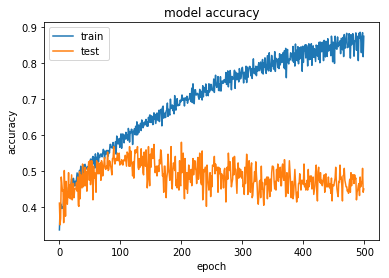

In [792]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

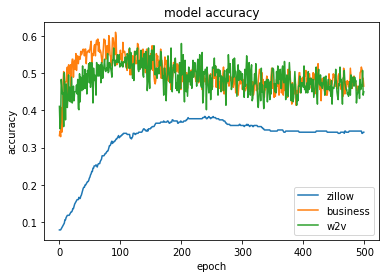

In [793]:
plt.plot(zillow_model.history['val_acc'])
plt.plot(business_model.history['val_acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['zillow', 'business', 'w2v'], loc='lower right')
plt.show()

#### Adding weights to classes

In [80]:
class_weight = {0 : 2,
    1: 1,
    2: .5,
    3: 1,
    4: 2}

In [924]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [925]:
zillow_model_2 = model.fit(x=X_train, y=y_cat_train, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 11s 4ms/step - loss: 1.4156 - acc: 0.3131 - val_loss: 1.4839 - val_acc: 0.3323
Epoch 2/1000
2839/2839 [==============================] - 0s 54us/step - loss: 1.3225 - acc: 0.3709 - val_loss: 1.4642 - val_acc: 0.3323
Epoch 3/1000
2839/2839 [==============================] - 0s 71us/step - loss: 1.3063 - acc: 0.3857 - val_loss: 1.4650 - val_acc: 0.3323
Epoch 4/1000
2839/2839 [==============================] - 0s 71us/step - loss: 1.2904 - acc: 0.3868 - val_loss: 1.4872 - val_acc: 0.3323
Epoch 5/1000
2839/2839 [==============================] - 0s 57us/step - loss: 1.2755 - acc: 0.3843 - val_loss: 1.4356 - val_acc: 0.3323
Epoch 6/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.2673 - acc: 0.3956 - val_loss: 1.4294 - val_acc: 0.3293
Epoch 7/1000
2839/2839 [==============================] - 0s 57us/step - loss: 1.2554 - acc: 0.4033 - val_loss: 1.4331 - val_acc: 0

2839/2839 [==============================] - 0s 67us/step - loss: 1.0379 - acc: 0.5019 - val_loss: 1.1848 - val_acc: 0.4773
Epoch 61/1000
2839/2839 [==============================] - 0s 60us/step - loss: 1.0154 - acc: 0.4868 - val_loss: 1.2053 - val_acc: 0.4562
Epoch 62/1000
2839/2839 [==============================] - 0s 58us/step - loss: 1.0020 - acc: 0.4917 - val_loss: 1.2435 - val_acc: 0.4502
Epoch 63/1000
2839/2839 [==============================] - 0s 53us/step - loss: 1.0054 - acc: 0.4854 - val_loss: 1.2872 - val_acc: 0.4350
Epoch 64/1000
2839/2839 [==============================] - 0s 47us/step - loss: 1.0154 - acc: 0.4882 - val_loss: 1.3260 - val_acc: 0.4139
Epoch 65/1000
2839/2839 [==============================] - 0s 43us/step - loss: 1.0199 - acc: 0.4664 - val_loss: 1.2977 - val_acc: 0.4139
Epoch 66/1000
2839/2839 [==============================] - 0s 67us/step - loss: 1.0044 - acc: 0.4741 - val_loss: 1.2520 - val_acc: 0.4230
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 49us/step - loss: 0.8561 - acc: 0.5505 - val_loss: 1.1264 - val_acc: 0.5136
Epoch 120/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.8743 - acc: 0.5523 - val_loss: 1.1574 - val_acc: 0.5076
Epoch 121/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.8585 - acc: 0.5484 - val_loss: 1.1684 - val_acc: 0.5015
Epoch 122/1000
2839/2839 [==============================] - 0s 49us/step - loss: 0.8316 - acc: 0.5611 - val_loss: 1.2272 - val_acc: 0.4955
Epoch 123/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.8350 - acc: 0.5449 - val_loss: 1.2799 - val_acc: 0.4411
Epoch 124/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.8690 - acc: 0.5372 - val_loss: 1.3184 - val_acc: 0.4260
Epoch 125/1000
2839/2839 [==============================] - 0s 46us/step - loss: 0.8606 - acc: 0.5301 - val_loss: 1.2453 - val_acc: 0.4804
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 44us/step - loss: 0.8216 - acc: 0.5410 - val_loss: 1.3008 - val_acc: 0.4743
Epoch 179/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.7633 - acc: 0.5738 - val_loss: 1.2943 - val_acc: 0.4743
Epoch 180/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7418 - acc: 0.5840 - val_loss: 1.2274 - val_acc: 0.5106
Epoch 181/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.7102 - acc: 0.6051 - val_loss: 1.1987 - val_acc: 0.5106
Epoch 182/1000
2839/2839 [==============================] - 0s 58us/step - loss: 0.7399 - acc: 0.6066 - val_loss: 1.1942 - val_acc: 0.5378
Epoch 183/1000
2839/2839 [==============================] - 0s 53us/step - loss: 0.7378 - acc: 0.6076 - val_loss: 1.1546 - val_acc: 0.5589
Epoch 184/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.7833 - acc: 0.5840 - val_loss: 1.1638 - val_acc: 0.5347
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 82us/step - loss: 0.6875 - acc: 0.6083 - val_loss: 1.3487 - val_acc: 0.4592
Epoch 238/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.6451 - acc: 0.6471 - val_loss: 1.3211 - val_acc: 0.4804
Epoch 239/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.6462 - acc: 0.6418 - val_loss: 1.3112 - val_acc: 0.4985
Epoch 240/1000
2839/2839 [==============================] - 0s 58us/step - loss: 0.6571 - acc: 0.6231 - val_loss: 1.3452 - val_acc: 0.4955
Epoch 241/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.6977 - acc: 0.6150 - val_loss: 1.2927 - val_acc: 0.5076
Epoch 242/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.6476 - acc: 0.6407 - val_loss: 1.3617 - val_acc: 0.4743
Epoch 243/1000
2839/2839 [==============================] - 0s 45us/step - loss: 0.6631 - acc: 0.6270 - val_loss: 1.4081 - val_acc: 0.4713
Epoch 244/1000
2839/2839 [================

Epoch 296/1000
2839/2839 [==============================] - 0s 55us/step - loss: 0.5751 - acc: 0.6735 - val_loss: 1.4885 - val_acc: 0.4381
Epoch 297/1000
2839/2839 [==============================] - 0s 52us/step - loss: 0.6080 - acc: 0.6442 - val_loss: 1.5358 - val_acc: 0.4079
Epoch 298/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.6114 - acc: 0.6446 - val_loss: 1.5102 - val_acc: 0.4320
Epoch 299/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.6331 - acc: 0.6365 - val_loss: 1.4240 - val_acc: 0.4683
Epoch 300/1000
2839/2839 [==============================] - 0s 51us/step - loss: 0.6427 - acc: 0.6340 - val_loss: 1.3605 - val_acc: 0.4804
Epoch 301/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5833 - acc: 0.6717 - val_loss: 1.3643 - val_acc: 0.4985
Epoch 302/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.6024 - acc: 0.6566 - val_loss: 1.3279 - val_acc: 0.5257
Epoch 303/1000
2839/2839 [=

Epoch 355/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5207 - acc: 0.6985 - val_loss: 1.5691 - val_acc: 0.4653
Epoch 356/1000
2839/2839 [==============================] - 0s 52us/step - loss: 0.5349 - acc: 0.6999 - val_loss: 1.5491 - val_acc: 0.4713
Epoch 357/1000
2839/2839 [==============================] - ETA: 0s - loss: 0.5304 - acc: 0.720 - 0s 68us/step - loss: 0.5321 - acc: 0.7094 - val_loss: 1.5232 - val_acc: 0.4834
Epoch 358/1000
2839/2839 [==============================] - 0s 55us/step - loss: 0.5422 - acc: 0.7010 - val_loss: 1.5650 - val_acc: 0.4653
Epoch 359/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.5529 - acc: 0.7024 - val_loss: 1.4502 - val_acc: 0.5106
Epoch 360/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.5579 - acc: 0.7013 - val_loss: 1.4629 - val_acc: 0.4924
Epoch 361/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.5305 - acc: 0.7073 - val_loss: 1.4687 - val_a

2839/2839 [==============================] - 0s 57us/step - loss: 0.4416 - acc: 0.7418 - val_loss: 1.7174 - val_acc: 0.4653
Epoch 473/1000
2839/2839 [==============================] - 0s 53us/step - loss: 0.4312 - acc: 0.7425 - val_loss: 1.7454 - val_acc: 0.4532
Epoch 474/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.4325 - acc: 0.7499 - val_loss: 1.7236 - val_acc: 0.4653
Epoch 475/1000
2839/2839 [==============================] - 0s 46us/step - loss: 0.4178 - acc: 0.7499 - val_loss: 1.7112 - val_acc: 0.4834
Epoch 476/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.4745 - acc: 0.7291 - val_loss: 1.6899 - val_acc: 0.4894
Epoch 477/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.5010 - acc: 0.7193 - val_loss: 1.6800 - val_acc: 0.4894
Epoch 478/1000
2839/2839 [==============================] - 0s 49us/step - loss: 0.4831 - acc: 0.7386 - val_loss: 1.7012 - val_acc: 0.4864
Epoch 479/1000
2839/2839 [================

2839/2839 [==============================] - 0s 53us/step - loss: 0.4375 - acc: 0.7524 - val_loss: 2.0388 - val_acc: 0.4230
Epoch 532/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4306 - acc: 0.7478 - val_loss: 1.9624 - val_acc: 0.4381
Epoch 533/1000
2839/2839 [==============================] - 0s 57us/step - loss: 0.4000 - acc: 0.7636 - val_loss: 1.9970 - val_acc: 0.4532
Epoch 534/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.3980 - acc: 0.7647 - val_loss: 2.0304 - val_acc: 0.4411
Epoch 535/1000
2839/2839 [==============================] - 0s 57us/step - loss: 0.4145 - acc: 0.7482 - val_loss: 2.0262 - val_acc: 0.4260
Epoch 536/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3977 - acc: 0.7629 - val_loss: 1.9830 - val_acc: 0.4441
Epoch 537/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.4018 - acc: 0.7732 - val_loss: 2.1867 - val_acc: 0.3897
Epoch 538/1000
2839/2839 [================

2839/2839 [==============================] - 0s 66us/step - loss: 0.4204 - acc: 0.7858 - val_loss: 1.9135 - val_acc: 0.4834
Epoch 591/1000
2839/2839 [==============================] - 0s 55us/step - loss: 0.3962 - acc: 0.7728 - val_loss: 1.9580 - val_acc: 0.4713
Epoch 592/1000
2839/2839 [==============================] - 0s 57us/step - loss: 0.3604 - acc: 0.7806 - val_loss: 2.0111 - val_acc: 0.4622
Epoch 593/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3846 - acc: 0.7658 - val_loss: 2.0315 - val_acc: 0.4683
Epoch 594/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.3889 - acc: 0.7679 - val_loss: 1.9708 - val_acc: 0.4743
Epoch 595/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.3849 - acc: 0.7661 - val_loss: 1.9576 - val_acc: 0.4955
Epoch 596/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.4015 - acc: 0.7651 - val_loss: 1.9733 - val_acc: 0.4894
Epoch 597/1000
2839/2839 [================

2839/2839 [==============================] - 0s 53us/step - loss: 0.3301 - acc: 0.8108 - val_loss: 2.1175 - val_acc: 0.5015
Epoch 650/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.3843 - acc: 0.7770 - val_loss: 2.2117 - val_acc: 0.4562
Epoch 651/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3664 - acc: 0.7728 - val_loss: 2.2064 - val_acc: 0.4411
Epoch 652/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.3268 - acc: 0.8027 - val_loss: 2.2466 - val_acc: 0.4350
Epoch 653/1000
2839/2839 [==============================] - 0s 83us/step - loss: 0.3245 - acc: 0.8130 - val_loss: 2.3132 - val_acc: 0.4199
Epoch 654/1000
2839/2839 [==============================] - 0s 53us/step - loss: 0.3537 - acc: 0.7985 - val_loss: 2.2104 - val_acc: 0.4713
Epoch 655/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.3351 - acc: 0.8144 - val_loss: 2.2345 - val_acc: 0.4502
Epoch 656/1000
2839/2839 [================

2839/2839 [==============================] - 0s 49us/step - loss: 0.2878 - acc: 0.8344 - val_loss: 2.2447 - val_acc: 0.4683
Epoch 709/1000
2839/2839 [==============================] - 0s 53us/step - loss: 0.3076 - acc: 0.8221 - val_loss: 2.2750 - val_acc: 0.4773
Epoch 710/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3289 - acc: 0.8080 - val_loss: 2.2463 - val_acc: 0.4955
Epoch 711/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.3446 - acc: 0.7943 - val_loss: 2.2648 - val_acc: 0.4743
Epoch 712/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3145 - acc: 0.8052 - val_loss: 2.3088 - val_acc: 0.4743
Epoch 713/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.3172 - acc: 0.8108 - val_loss: 2.2718 - val_acc: 0.4804
Epoch 714/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3144 - acc: 0.8126 - val_loss: 2.3085 - val_acc: 0.4834
Epoch 715/1000
2839/2839 [================

2839/2839 [==============================] - 0s 61us/step - loss: 0.2841 - acc: 0.8429 - val_loss: 2.4318 - val_acc: 0.4532
Epoch 768/1000
2839/2839 [==============================] - 0s 54us/step - loss: 0.2864 - acc: 0.8369 - val_loss: 2.5240 - val_acc: 0.4350
Epoch 769/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3259 - acc: 0.8204 - val_loss: 2.7712 - val_acc: 0.3837
Epoch 770/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.4380 - acc: 0.7485 - val_loss: 2.6510 - val_acc: 0.4471
Epoch 771/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3576 - acc: 0.8027 - val_loss: 2.3611 - val_acc: 0.4713
Epoch 772/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.2785 - acc: 0.8454 - val_loss: 2.2588 - val_acc: 0.4894
Epoch 773/1000
2839/2839 [==============================] - 0s 84us/step - loss: 0.2995 - acc: 0.8302 - val_loss: 2.2783 - val_acc: 0.4834
Epoch 774/1000
2839/2839 [================

2839/2839 [==============================] - 0s 56us/step - loss: 0.2793 - acc: 0.8369 - val_loss: 2.5447 - val_acc: 0.4411
Epoch 827/1000
2839/2839 [==============================] - 0s 58us/step - loss: 0.2855 - acc: 0.8158 - val_loss: 2.5001 - val_acc: 0.4622
Epoch 828/1000
2839/2839 [==============================] - 0s 84us/step - loss: 0.2792 - acc: 0.8260 - val_loss: 2.5304 - val_acc: 0.4834
Epoch 829/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.2628 - acc: 0.8359 - val_loss: 2.6068 - val_acc: 0.4502
Epoch 830/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.3238 - acc: 0.7918 - val_loss: 2.5490 - val_acc: 0.4683
Epoch 831/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.2744 - acc: 0.8404 - val_loss: 2.4656 - val_acc: 0.4804
Epoch 832/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.2809 - acc: 0.8316 - val_loss: 2.4608 - val_acc: 0.4924
Epoch 833/1000
2839/2839 [================

2839/2839 [==============================] - 0s 46us/step - loss: 0.2369 - acc: 0.8464 - val_loss: 2.6145 - val_acc: 0.4743
Epoch 886/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.2422 - acc: 0.8693 - val_loss: 2.5842 - val_acc: 0.4834
Epoch 887/1000
2839/2839 [==============================] - 0s 56us/step - loss: 0.2911 - acc: 0.8542 - val_loss: 2.4856 - val_acc: 0.5136
Epoch 888/1000
2839/2839 [==============================] - 0s 45us/step - loss: 0.3224 - acc: 0.8415 - val_loss: 2.5095 - val_acc: 0.4985
Epoch 889/1000
2839/2839 [==============================] - 0s 51us/step - loss: 0.2543 - acc: 0.8580 - val_loss: 2.6045 - val_acc: 0.5015
Epoch 890/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.2390 - acc: 0.8619 - val_loss: 2.5989 - val_acc: 0.4924
Epoch 891/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.2415 - acc: 0.8633 - val_loss: 2.6559 - val_acc: 0.4532
Epoch 892/1000
2839/2839 [================

In [1187]:
df_zillow_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(120,), activation='relu'))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    zillow_model_2 = model.fit(x=X_train, y=y_cat_train, 
          batch_size=2000, 
          epochs=150, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test)
    loss = zillow_model_2.history['val_loss'][-1]
    acc = zillow_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean = model_metrics(predictions, y_cat_test)
    df_zillow_analysis.loc[num,'pred_count'] = gain_pred
    df_zillow_analysis.loc[num,'gain_10%'] = gain_large_true_large
    df_zillow_analysis.loc[num,'gain_3%'] = gain_true
    df_zillow_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_zillow_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_zillow_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_zillow_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_zillow_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_zillow_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_zillow_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_zillow_analysis.loc[num,'loss'] = loss
    df_zillow_analysis.loc[num,'acc'] = acc
    print(num)
df_150_z = df_zillow_analysis
df_zillow_analysis

Train on 2839 samples, validate on 331 samples
Epoch 1/150
2839/2839 [==============================] - 25s 9ms/step - loss: 1.4665 - acc: 0.2335 - val_loss: 1.5538 - val_acc: 0.3323
Epoch 2/150
2839/2839 [==============================] - 0s 37us/step - loss: 1.3345 - acc: 0.3353 - val_loss: 1.5288 - val_acc: 0.3293
Epoch 3/150
2839/2839 [==============================] - 0s 38us/step - loss: 1.3296 - acc: 0.3241 - val_loss: 1.4801 - val_acc: 0.3263
Epoch 4/150
2839/2839 [==============================] - 0s 37us/step - loss: 1.2943 - acc: 0.3575 - val_loss: 1.4591 - val_acc: 0.3293
Epoch 5/150
2839/2839 [==============================] - 0s 39us/step - loss: 1.2981 - acc: 0.3575 - val_loss: 1.4667 - val_acc: 0.3142
Epoch 6/150
2839/2839 [==============================] - 0s 40us/step - loss: 1.2871 - acc: 0.3568 - val_loss: 1.4313 - val_acc: 0.3293
Epoch 7/150
2839/2839 [==============================] - 0s 40us/step - loss: 1.2726 - acc: 0.3783 - val_loss: 1.4390 - val_acc: 0.3293
E

Epoch 120/150
2839/2839 [==============================] - 0s 44us/step - loss: 0.8482 - acc: 0.5414 - val_loss: 1.1879 - val_acc: 0.4864
Epoch 121/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.8438 - acc: 0.5516 - val_loss: 1.1806 - val_acc: 0.5106
Epoch 122/150
2839/2839 [==============================] - 0s 39us/step - loss: 0.8472 - acc: 0.5456 - val_loss: 1.2722 - val_acc: 0.4592
Epoch 123/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.8467 - acc: 0.5442 - val_loss: 1.2533 - val_acc: 0.4592
Epoch 124/150
2839/2839 [==============================] - 0s 36us/step - loss: 0.8436 - acc: 0.5446 - val_loss: 1.3276 - val_acc: 0.4199
Epoch 125/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.8720 - acc: 0.5294 - val_loss: 1.2864 - val_acc: 0.4320
Epoch 126/150
2839/2839 [==============================] - 0s 37us/step - loss: 0.8558 - acc: 0.5368 - val_loss: 1.2677 - val_acc: 0.4350
Epoch 127/150
2839/2839 [=========

Epoch 89/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.9628 - acc: 0.5093 - val_loss: 1.3351 - val_acc: 0.4109
Epoch 90/150
2839/2839 [==============================] - 0s 40us/step - loss: 0.9738 - acc: 0.4794 - val_loss: 1.1932 - val_acc: 0.4894
Epoch 91/150
2839/2839 [==============================] - 0s 39us/step - loss: 0.9238 - acc: 0.5114 - val_loss: 1.2073 - val_acc: 0.4894
Epoch 92/150
2839/2839 [==============================] - 0s 41us/step - loss: 0.9475 - acc: 0.5069 - val_loss: 1.1300 - val_acc: 0.5408
Epoch 93/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.9445 - acc: 0.5146 - val_loss: 1.1023 - val_acc: 0.5801
Epoch 94/150
2839/2839 [==============================] - 0s 39us/step - loss: 0.9228 - acc: 0.5305 - val_loss: 1.0843 - val_acc: 0.5589
Epoch 95/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.9404 - acc: 0.5238 - val_loss: 1.0955 - val_acc: 0.5317
Epoch 96/150
2839/2839 [=================

2839/2839 [==============================] - 0s 40us/step - loss: 1.0056 - acc: 0.4748 - val_loss: 1.1469 - val_acc: 0.5076
Epoch 58/150
2839/2839 [==============================] - 0s 42us/step - loss: 1.0387 - acc: 0.4720 - val_loss: 1.1898 - val_acc: 0.4924
Epoch 59/150
2839/2839 [==============================] - 0s 41us/step - loss: 1.0005 - acc: 0.4822 - val_loss: 1.2122 - val_acc: 0.4653
Epoch 60/150
2839/2839 [==============================] - 0s 41us/step - loss: 0.9990 - acc: 0.4699 - val_loss: 1.1960 - val_acc: 0.4864
Epoch 61/150
2839/2839 [==============================] - 0s 37us/step - loss: 0.9954 - acc: 0.4738 - val_loss: 1.1780 - val_acc: 0.4532
Epoch 62/150
2839/2839 [==============================] - 0s 39us/step - loss: 1.0150 - acc: 0.4773 - val_loss: 1.1675 - val_acc: 0.4622
Epoch 63/150
2839/2839 [==============================] - 0s 39us/step - loss: 1.0062 - acc: 0.4635 - val_loss: 1.1710 - val_acc: 0.4955
Epoch 64/150
2839/2839 [==============================

Epoch 117/150
2839/2839 [==============================] - 0s 41us/step - loss: 0.8667 - acc: 0.5224 - val_loss: 1.2394 - val_acc: 0.4924
Epoch 118/150
2839/2839 [==============================] - 0s 41us/step - loss: 0.8527 - acc: 0.5347 - val_loss: 1.2662 - val_acc: 0.4743
Epoch 119/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.8431 - acc: 0.5350 - val_loss: 1.2721 - val_acc: 0.4713
Epoch 120/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.8523 - acc: 0.5403 - val_loss: 1.3427 - val_acc: 0.4471
Epoch 121/150
2839/2839 [==============================] - 0s 37us/step - loss: 0.8689 - acc: 0.5188 - val_loss: 1.2446 - val_acc: 0.4743
Epoch 122/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.8353 - acc: 0.5474 - val_loss: 1.2407 - val_acc: 0.4834
Epoch 123/150
2839/2839 [==============================] - 0s 38us/step - loss: 0.8464 - acc: 0.5358 - val_loss: 1.3209 - val_acc: 0.4562
Epoch 124/150
2839/2839 [=========

2839/2839 [==============================] - 0s 37us/step - loss: 0.9828 - acc: 0.4998 - val_loss: 1.1508 - val_acc: 0.5287
Epoch 86/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.9686 - acc: 0.4967 - val_loss: 1.2110 - val_acc: 0.4592
Epoch 87/150
2839/2839 [==============================] - 0s 36us/step - loss: 0.9608 - acc: 0.4900 - val_loss: 1.1859 - val_acc: 0.5166
Epoch 88/150
2839/2839 [==============================] - 0s 36us/step - loss: 0.9658 - acc: 0.5055 - val_loss: 1.1446 - val_acc: 0.5287
Epoch 89/150
2839/2839 [==============================] - 0s 34us/step - loss: 0.9625 - acc: 0.5114 - val_loss: 1.1543 - val_acc: 0.5347
Epoch 90/150
2839/2839 [==============================] - 0s 41us/step - loss: 0.9616 - acc: 0.5062 - val_loss: 1.1489 - val_acc: 0.5589
Epoch 91/150
2839/2839 [==============================] - 0s 34us/step - loss: 0.9866 - acc: 0.4974 - val_loss: 1.1182 - val_acc: 0.5680
Epoch 92/150
2839/2839 [==============================

2839/2839 [==============================] - 0s 37us/step - loss: 1.0585 - acc: 0.4477 - val_loss: 1.3605 - val_acc: 0.3414
Epoch 54/150
2839/2839 [==============================] - 0s 39us/step - loss: 1.0592 - acc: 0.4449 - val_loss: 1.2749 - val_acc: 0.3807
Epoch 55/150
2839/2839 [==============================] - 0s 36us/step - loss: 1.0247 - acc: 0.4639 - val_loss: 1.2631 - val_acc: 0.4139
Epoch 56/150
2839/2839 [==============================] - 0s 39us/step - loss: 1.0355 - acc: 0.4607 - val_loss: 1.2453 - val_acc: 0.4230
Epoch 57/150
2839/2839 [==============================] - 0s 36us/step - loss: 1.0237 - acc: 0.4674 - val_loss: 1.2444 - val_acc: 0.3958
Epoch 58/150
2839/2839 [==============================] - 0s 36us/step - loss: 1.0107 - acc: 0.4741 - val_loss: 1.2813 - val_acc: 0.3746
Epoch 59/150
2839/2839 [==============================] - 0s 36us/step - loss: 1.0310 - acc: 0.4628 - val_loss: 1.3442 - val_acc: 0.3505
Epoch 60/150
2839/2839 [==============================

Epoch 113/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.8850 - acc: 0.5400 - val_loss: 1.2989 - val_acc: 0.4743
Epoch 114/150
2839/2839 [==============================] - 0s 36us/step - loss: 0.9132 - acc: 0.5100 - val_loss: 1.2103 - val_acc: 0.5015
Epoch 115/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.8530 - acc: 0.5435 - val_loss: 1.1983 - val_acc: 0.5196
Epoch 116/150
2839/2839 [==============================] - 0s 35us/step - loss: 0.8700 - acc: 0.5181 - val_loss: 1.1880 - val_acc: 0.5166
Epoch 117/150
2839/2839 [==============================] - 0s 37us/step - loss: 0.8778 - acc: 0.5393 - val_loss: 1.1756 - val_acc: 0.5438
Epoch 118/150
2839/2839 [==============================] - 0s 37us/step - loss: 0.8515 - acc: 0.5389 - val_loss: 1.1821 - val_acc: 0.5347
Epoch 119/150
2839/2839 [==============================] - 0s 36us/step - loss: 0.8463 - acc: 0.5435 - val_loss: 1.1915 - val_acc: 0.5136
Epoch 120/150
2839/2839 [=========

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,106.0,0.094972,0.754717,0.952830,0.272727,0.787879,0.939394,0.081481,0.525926,0.851852,1.184601,0.483384
1,114.0,0.094972,0.745614,0.956140,0.303030,0.757576,0.878788,0.070312,0.507812,0.843750,1.175836,0.480363
2,152.0,0.094972,0.651316,0.953947,0.303030,0.757576,0.909091,0.084746,0.525424,0.847458,1.226775,0.474320
3,142.0,0.094972,0.676056,0.950704,0.333333,0.818182,0.939394,0.093750,0.506250,0.862500,1.246916,0.459215
4,113.0,0.094972,0.734513,0.938053,0.242424,0.787879,0.939394,0.110345,0.475862,0.882759,1.179244,0.513595


In [1178]:
df_400_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,90.0,0.094972,0.744444,0.955556,0.242424,0.727273,0.878788,0.071429,0.531746,0.857143,1.491803,0.498489
1,140.0,0.094972,0.678571,0.950000,0.272727,0.727273,0.878788,0.081395,0.488372,0.843023,1.549860,0.453172
2,169.0,0.094972,0.609467,0.923077,0.333333,0.727273,0.878788,0.075377,0.482412,0.854271,1.910163,0.365559
3,108.0,0.094972,0.731481,0.953704,0.303030,0.787879,0.909091,0.103448,0.510345,0.868966,1.516773,0.492447
4,139.0,0.094972,0.647482,0.935252,0.303030,0.727273,0.878788,0.090909,0.490909,0.860606,1.829167,0.353474


In [1180]:
df_400_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,78.0,0.094972,0.794872,0.974359,0.272727,0.818182,0.969697,0.085106,0.468085,0.861702,1.826030,0.380665
1,125.0,0.094972,0.696000,0.952000,0.242424,0.757576,0.909091,0.086667,0.466667,0.860000,1.714454,0.432024
2,119.0,0.094972,0.663866,0.941176,0.272727,0.727273,0.909091,0.079137,0.482014,0.892086,1.827232,0.413897
3,93.0,0.094972,0.741935,0.956989,0.242424,0.696970,0.909091,0.084034,0.436975,0.848739,1.764446,0.465257
4,72.0,0.094972,0.777778,0.958333,0.242424,0.757576,0.939394,0.068627,0.480392,0.833333,1.480029,0.498489


In [1176]:
df_300_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,116.0,0.094972,0.724138,0.965517,0.272727,0.757576,0.909091,0.055556,0.472222,0.861111,1.484431,0.459215
1,72.0,0.094972,0.791667,0.958333,0.242424,0.757576,0.939394,0.120000,0.540000,0.910000,1.330855,0.534743
2,160.0,0.094972,0.631250,0.937500,0.303030,0.818182,0.939394,0.076142,0.482234,0.878173,1.462107,0.480363
3,109.0,0.094972,0.752294,0.963303,0.242424,0.757576,0.878788,0.070922,0.468085,0.872340,1.376176,0.531722
4,94.0,0.094972,0.755319,0.957447,0.242424,0.757576,0.939394,0.092199,0.475177,0.865248,1.363008,0.519637


In [1182]:
df_300_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,123.0,0.094972,0.707317,0.951220,0.272727,0.757576,0.878788,0.064935,0.461039,0.844156,1.434881,0.507553
1,97.0,0.094972,0.731959,0.969072,0.242424,0.787879,0.939394,0.090909,0.518182,0.909091,1.450340,0.459215
2,95.0,0.094972,0.789474,0.957895,0.242424,0.787879,0.939394,0.077778,0.488889,0.888889,1.533402,0.471299
3,89.0,0.094972,0.741573,0.943820,0.272727,0.787879,0.909091,0.083969,0.488550,0.870229,1.348234,0.513595
4,110.0,0.094972,0.709091,0.936364,0.242424,0.727273,0.909091,0.089655,0.496552,0.868966,1.400084,0.486405


In [1170]:
df_250_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,137.0,0.094972,0.671533,0.948905,0.272727,0.787879,0.939394,0.088435,0.537415,0.863946,1.421515,0.510574
1,94.0,0.094972,0.797872,0.957447,0.272727,0.757576,0.909091,0.090090,0.540541,0.846847,1.469787,0.468278
2,157.0,0.094972,0.636943,0.936306,0.303030,0.727273,0.878788,0.075676,0.470270,0.881081,1.468260,0.465257
3,115.0,0.094972,0.739130,0.956522,0.303030,0.757576,0.909091,0.101562,0.500000,0.859375,1.435143,0.480363
4,144.0,0.094972,0.659722,0.951389,0.272727,0.727273,0.909091,0.076471,0.494118,0.876471,1.542414,0.432024


In [1184]:
df_250_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,125.0,0.094972,0.704000,0.968000,0.272727,0.727273,0.909091,0.093960,0.463087,0.852349,1.548896,0.432024
1,88.0,0.094972,0.784091,0.965909,0.272727,0.757576,0.909091,0.115044,0.522124,0.858407,1.321403,0.489426
2,70.0,0.094972,0.757143,0.942857,0.242424,0.787879,0.939394,0.048780,0.495935,0.861789,1.274005,0.546828
3,92.0,0.094972,0.739130,0.934783,0.272727,0.757576,0.939394,0.112903,0.532258,0.830645,1.325635,0.489426
4,98.0,0.094972,0.775510,0.959184,0.242424,0.818182,0.939394,0.094488,0.535433,0.881890,1.214646,0.540785


In [1172]:
df_200_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,163.0,0.094972,0.625767,0.938650,0.303030,0.757576,0.909091,0.083770,0.465969,0.879581,1.407345,0.474320
1,144.0,0.094972,0.659722,0.951389,0.303030,0.787879,0.909091,0.092025,0.496933,0.883436,1.437591,0.483384
2,136.0,0.094972,0.669118,0.955882,0.303030,0.787879,0.969697,0.096970,0.515152,0.878788,1.464218,0.465257
3,133.0,0.094972,0.676692,0.954887,0.272727,0.787879,0.909091,0.095890,0.472603,0.842466,1.397490,0.480363
4,110.0,0.094972,0.754545,0.963636,0.272727,0.787879,0.939394,0.097561,0.495935,0.886179,1.270403,0.543807


In [1186]:
df_200_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,93.0,0.094972,0.795699,0.956989,0.272727,0.848485,0.969697,0.094828,0.439655,0.818966,1.196810,0.546828
1,103.0,0.094972,0.718447,0.932039,0.242424,0.757576,0.939394,0.097561,0.430894,0.829268,1.307886,0.483384
2,88.0,0.094972,0.784091,0.954545,0.242424,0.787879,0.939394,0.082569,0.495413,0.871560,1.204385,0.525680
3,82.0,0.094972,0.804878,0.951220,0.242424,0.787879,0.969697,0.078431,0.500000,0.803922,1.294213,0.492447
4,95.0,0.094972,0.768421,0.957895,0.242424,0.787879,0.939394,0.093525,0.525180,0.856115,1.235405,0.489426


In [1174]:
df_150_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.815789,0.960526,0.212121,0.787879,0.969697,0.107438,0.545455,0.884298,1.245467,0.580060
1,148.0,0.094972,0.668919,0.952703,0.272727,0.818182,0.939394,0.077778,0.461111,0.827778,1.352093,0.513595
2,180.0,0.094972,0.611111,0.916667,0.303030,0.727273,0.909091,0.070796,0.469027,0.858407,1.461635,0.407855
3,169.0,0.094972,0.633136,0.934911,0.272727,0.757576,0.909091,0.071429,0.464286,0.862245,1.357489,0.483384
4,170.0,0.094972,0.623529,0.947059,0.303030,0.787879,0.939394,0.096257,0.524064,0.887701,1.349806,0.474320


In [1188]:
df_150_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,106.0,0.094972,0.754717,0.952830,0.272727,0.787879,0.939394,0.081481,0.525926,0.851852,1.184601,0.483384
1,114.0,0.094972,0.745614,0.956140,0.303030,0.757576,0.878788,0.070312,0.507812,0.843750,1.175836,0.480363
2,152.0,0.094972,0.651316,0.953947,0.303030,0.757576,0.909091,0.084746,0.525424,0.847458,1.226775,0.474320
3,142.0,0.094972,0.676056,0.950704,0.333333,0.818182,0.939394,0.093750,0.506250,0.862500,1.246916,0.459215
4,113.0,0.094972,0.734513,0.938053,0.242424,0.787879,0.939394,0.110345,0.475862,0.882759,1.179244,0.513595


In [1189]:
predictions = model.predict(X_test)
model_metrics(predictions, y_cat_test)

(113,
 0.13274336283185842,
 0.7345132743362832,
 0.9380530973451328,
 0.24242424242424243,
 0.7878787878787878,
 0.9393939393939394,
 0.47586206896551725,
 0.1103448275862069,
 0.8827586206896552)

In [927]:
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

array([[ 1, 11,  6,  4,  1],
       [ 3, 18, 21,  6,  1],
       [ 1, 15, 84, 34,  4],
       [ 0,  5, 27, 53,  7],
       [ 0,  3,  6, 13,  7]])

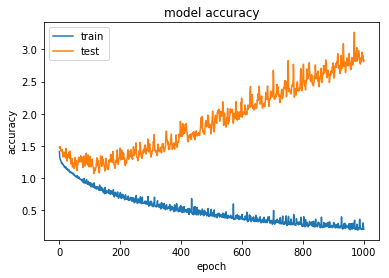

In [930]:
plt.plot(zillow_model_2.history['loss'])
plt.plot(zillow_model_2.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [920]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [921]:
business_model_2 = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 5s 2ms/step - loss: 1.6146 - acc: 0.3251 - val_loss: 1.4759 - val_acc: 0.3293
Epoch 2/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.4039 - acc: 0.3730 - val_loss: 1.4592 - val_acc: 0.3535
Epoch 3/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3817 - acc: 0.3720 - val_loss: 1.4878 - val_acc: 0.3535
Epoch 4/1000
2839/2839 [==============================] - 0s 34us/step - loss: 1.3932 - acc: 0.3529 - val_loss: 1.4750 - val_acc: 0.3505
Epoch 5/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3626 - acc: 0.3688 - val_loss: 1.4523 - val_acc: 0.3323
Epoch 6/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3616 - acc: 0.3614 - val_loss: 1.4692 - val_acc: 0.3323
Epoch 7/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3562 - acc: 0.3656 - val_loss: 1.4888 - val_acc: 0.

2839/2839 [==============================] - 0s 33us/step - loss: 1.1434 - acc: 0.4174 - val_loss: 1.3567 - val_acc: 0.3625
Epoch 61/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1196 - acc: 0.4477 - val_loss: 1.3434 - val_acc: 0.3505
Epoch 62/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1252 - acc: 0.4406 - val_loss: 1.3087 - val_acc: 0.3625
Epoch 63/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.1172 - acc: 0.4477 - val_loss: 1.3571 - val_acc: 0.3565
Epoch 64/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1252 - acc: 0.4347 - val_loss: 1.3387 - val_acc: 0.3414
Epoch 65/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1044 - acc: 0.4396 - val_loss: 1.3362 - val_acc: 0.3505
Epoch 66/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.1102 - acc: 0.4480 - val_loss: 1.2925 - val_acc: 0.4320
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 31us/step - loss: 0.8581 - acc: 0.5523 - val_loss: 1.1922 - val_acc: 0.4985
Epoch 179/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8660 - acc: 0.5608 - val_loss: 1.1334 - val_acc: 0.5438
Epoch 180/1000
2839/2839 [==============================] - 0s 37us/step - loss: 0.9014 - acc: 0.5544 - val_loss: 1.1159 - val_acc: 0.5589
Epoch 181/1000
2839/2839 [==============================] - 0s 45us/step - loss: 0.8800 - acc: 0.5460 - val_loss: 1.1383 - val_acc: 0.5498
Epoch 182/1000
2839/2839 [==============================] - 0s 39us/step - loss: 0.8430 - acc: 0.5706 - val_loss: 1.1845 - val_acc: 0.5378
Epoch 183/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.8312 - acc: 0.5615 - val_loss: 1.2498 - val_acc: 0.4773
Epoch 184/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8577 - acc: 0.5280 - val_loss: 1.1801 - val_acc: 0.5317
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.7549 - acc: 0.5970 - val_loss: 1.2186 - val_acc: 0.4924
Epoch 238/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7460 - acc: 0.6006 - val_loss: 1.2622 - val_acc: 0.4562
Epoch 239/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7772 - acc: 0.5903 - val_loss: 1.2153 - val_acc: 0.4743
Epoch 240/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8066 - acc: 0.5879 - val_loss: 1.1779 - val_acc: 0.5438
Epoch 241/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7605 - acc: 0.5992 - val_loss: 1.1643 - val_acc: 0.5589
Epoch 242/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7626 - acc: 0.5949 - val_loss: 1.1857 - val_acc: 0.5468
Epoch 243/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7487 - acc: 0.5953 - val_loss: 1.1862 - val_acc: 0.5408
Epoch 244/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.6779 - acc: 0.6333 - val_loss: 1.3068 - val_acc: 0.4471
Epoch 297/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6922 - acc: 0.6164 - val_loss: 1.2524 - val_acc: 0.5438
Epoch 298/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7540 - acc: 0.6157 - val_loss: 1.2515 - val_acc: 0.5166
Epoch 299/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7005 - acc: 0.6309 - val_loss: 1.2825 - val_acc: 0.5045
Epoch 300/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6422 - acc: 0.6393 - val_loss: 1.2678 - val_acc: 0.5227
Epoch 301/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6570 - acc: 0.6323 - val_loss: 1.2778 - val_acc: 0.5166
Epoch 302/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6695 - acc: 0.6330 - val_loss: 1.2575 - val_acc: 0.5166
Epoch 303/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.6054 - acc: 0.6576 - val_loss: 1.3524 - val_acc: 0.4985
Epoch 356/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6131 - acc: 0.6615 - val_loss: 1.3875 - val_acc: 0.4592
Epoch 357/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6850 - acc: 0.6467 - val_loss: 1.3602 - val_acc: 0.4773
Epoch 358/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6203 - acc: 0.6626 - val_loss: 1.3408 - val_acc: 0.5015
Epoch 359/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5910 - acc: 0.6735 - val_loss: 1.3500 - val_acc: 0.4834
Epoch 360/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5842 - acc: 0.6756 - val_loss: 1.3325 - val_acc: 0.5136
Epoch 361/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5977 - acc: 0.6622 - val_loss: 1.3584 - val_acc: 0.5076
Epoch 362/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.5864 - acc: 0.6728 - val_loss: 1.4192 - val_acc: 0.5166
Epoch 415/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5925 - acc: 0.6604 - val_loss: 1.4075 - val_acc: 0.5166
Epoch 416/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5680 - acc: 0.6742 - val_loss: 1.4051 - val_acc: 0.4985
Epoch 417/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5385 - acc: 0.6974 - val_loss: 1.4271 - val_acc: 0.5136
Epoch 418/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5695 - acc: 0.6833 - val_loss: 1.4629 - val_acc: 0.4924
Epoch 419/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6408 - acc: 0.6664 - val_loss: 1.4902 - val_acc: 0.4773
Epoch 420/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6436 - acc: 0.6816 - val_loss: 1.4800 - val_acc: 0.4350
Epoch 421/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.4763 - acc: 0.7281 - val_loss: 1.6324 - val_acc: 0.4320
Epoch 474/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4798 - acc: 0.7224 - val_loss: 1.5717 - val_acc: 0.4834
Epoch 475/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5186 - acc: 0.7010 - val_loss: 1.5448 - val_acc: 0.5468
Epoch 476/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5895 - acc: 0.6766 - val_loss: 1.4863 - val_acc: 0.5287
Epoch 477/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5215 - acc: 0.7038 - val_loss: 1.5639 - val_acc: 0.4592
Epoch 478/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5150 - acc: 0.7055 - val_loss: 1.6006 - val_acc: 0.4622
Epoch 479/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6084 - acc: 0.6847 - val_loss: 1.5969 - val_acc: 0.4622
Epoch 480/1000
2839/2839 [================

2839/2839 [==============================] - 0s 29us/step - loss: 0.5438 - acc: 0.6869 - val_loss: 1.7172 - val_acc: 0.4350
Epoch 533/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4698 - acc: 0.7291 - val_loss: 1.7266 - val_acc: 0.4290
Epoch 534/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4745 - acc: 0.7390 - val_loss: 1.7652 - val_acc: 0.4169
Epoch 535/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4531 - acc: 0.7443 - val_loss: 1.8121 - val_acc: 0.4018
Epoch 536/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4907 - acc: 0.7408 - val_loss: 1.8143 - val_acc: 0.4139
Epoch 537/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.5148 - acc: 0.7390 - val_loss: 1.7456 - val_acc: 0.4290
Epoch 538/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4563 - acc: 0.7460 - val_loss: 1.7292 - val_acc: 0.4411
Epoch 539/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.4840 - acc: 0.7538 - val_loss: 1.7835 - val_acc: 0.4441
Epoch 592/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4370 - acc: 0.7531 - val_loss: 1.7909 - val_acc: 0.4924
Epoch 593/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4927 - acc: 0.7309 - val_loss: 1.7372 - val_acc: 0.5227
Epoch 594/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4499 - acc: 0.7584 - val_loss: 1.7562 - val_acc: 0.5045
Epoch 595/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4192 - acc: 0.7510 - val_loss: 1.7417 - val_acc: 0.5196
Epoch 596/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4385 - acc: 0.7524 - val_loss: 1.7531 - val_acc: 0.5106
Epoch 597/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4510 - acc: 0.7397 - val_loss: 1.7830 - val_acc: 0.5136
Epoch 598/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.4344 - acc: 0.7474 - val_loss: 1.9657 - val_acc: 0.4381
Epoch 651/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4154 - acc: 0.7608 - val_loss: 1.9353 - val_acc: 0.4804
Epoch 652/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4084 - acc: 0.7598 - val_loss: 1.9285 - val_acc: 0.5045
Epoch 653/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4901 - acc: 0.7126 - val_loss: 1.8760 - val_acc: 0.5136
Epoch 654/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4496 - acc: 0.7327 - val_loss: 1.9373 - val_acc: 0.4773
Epoch 655/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3860 - acc: 0.7732 - val_loss: 1.9604 - val_acc: 0.4804
Epoch 656/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3930 - acc: 0.7732 - val_loss: 1.9718 - val_acc: 0.4864
Epoch 657/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.4011 - acc: 0.7693 - val_loss: 2.1153 - val_acc: 0.4804
Epoch 710/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4292 - acc: 0.7770 - val_loss: 2.0807 - val_acc: 0.4622
Epoch 711/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.3673 - acc: 0.8006 - val_loss: 2.0683 - val_acc: 0.4834
Epoch 712/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3503 - acc: 0.8105 - val_loss: 2.1499 - val_acc: 0.4441
Epoch 713/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3608 - acc: 0.7968 - val_loss: 2.1500 - val_acc: 0.4532
Epoch 714/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3721 - acc: 0.7858 - val_loss: 2.2279 - val_acc: 0.4320
Epoch 715/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3813 - acc: 0.7932 - val_loss: 2.3359 - val_acc: 0.3837
Epoch 716/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.3596 - acc: 0.8010 - val_loss: 2.1307 - val_acc: 0.4924
Epoch 769/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3850 - acc: 0.7813 - val_loss: 2.1863 - val_acc: 0.4743
Epoch 770/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3639 - acc: 0.7837 - val_loss: 2.1767 - val_acc: 0.4592
Epoch 771/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3490 - acc: 0.7989 - val_loss: 2.2360 - val_acc: 0.4230
Epoch 772/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3561 - acc: 0.8087 - val_loss: 2.2669 - val_acc: 0.4139
Epoch 773/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3750 - acc: 0.7915 - val_loss: 2.2552 - val_acc: 0.4350
Epoch 774/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3520 - acc: 0.8137 - val_loss: 2.3940 - val_acc: 0.4320
Epoch 775/1000
2839/2839 [================

2839/2839 [==============================] - 0s 33us/step - loss: 0.3463 - acc: 0.8175 - val_loss: 2.3973 - val_acc: 0.4622
Epoch 828/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3257 - acc: 0.8274 - val_loss: 2.4001 - val_acc: 0.4441
Epoch 829/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3385 - acc: 0.8228 - val_loss: 2.4106 - val_acc: 0.4350
Epoch 830/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3276 - acc: 0.8267 - val_loss: 2.4299 - val_acc: 0.4411
Epoch 831/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3360 - acc: 0.8256 - val_loss: 2.4576 - val_acc: 0.4532
Epoch 832/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3335 - acc: 0.8214 - val_loss: 2.4817 - val_acc: 0.4471
Epoch 833/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3592 - acc: 0.8098 - val_loss: 2.3778 - val_acc: 0.4532
Epoch 834/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.3377 - acc: 0.8221 - val_loss: 2.5212 - val_acc: 0.4502
Epoch 887/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3167 - acc: 0.8281 - val_loss: 2.4643 - val_acc: 0.4592
Epoch 888/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2930 - acc: 0.8366 - val_loss: 2.5055 - val_acc: 0.4532
Epoch 889/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3002 - acc: 0.8422 - val_loss: 2.4225 - val_acc: 0.4562
Epoch 890/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3794 - acc: 0.8077 - val_loss: 2.4469 - val_acc: 0.4441
Epoch 891/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3448 - acc: 0.8101 - val_loss: 2.3573 - val_acc: 0.4743
Epoch 892/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2797 - acc: 0.8401 - val_loss: 2.3886 - val_acc: 0.4894
Epoch 893/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.2620 - acc: 0.8507 - val_loss: 2.4797 - val_acc: 0.4804
Epoch 946/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.2850 - acc: 0.8492 - val_loss: 2.5642 - val_acc: 0.4653
Epoch 947/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.2791 - acc: 0.8563 - val_loss: 2.6377 - val_acc: 0.4532
Epoch 948/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3217 - acc: 0.8418 - val_loss: 2.6458 - val_acc: 0.4532
Epoch 949/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3255 - acc: 0.8337 - val_loss: 2.5759 - val_acc: 0.4622
Epoch 950/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3131 - acc: 0.8440 - val_loss: 2.6168 - val_acc: 0.4411
Epoch 951/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3006 - acc: 0.8422 - val_loss: 2.5850 - val_acc: 0.4653
Epoch 952/1000
2839/2839 [================

In [87]:
df_business_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(130,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    business_model_2 = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=250, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_business)
    loss = business_model_2.history['val_loss'][-1]
    acc = business_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean = model_metrics(predictions, y_cat_test_business)
    df_business_analysis.loc[num,'pred_count'] = gain_pred
    df_business_analysis.loc[num,'gain_10%'] = gain_large_true_large
    df_business_analysis.loc[num,'gain_3%'] = gain_true
    df_business_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_business_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_business_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_business_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_business_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_business_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_business_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_business_analysis.loc[num,'loss'] = loss
    df_business_analysis.loc[num,'acc'] = acc
    print(num)
df_175_w_b = df_business_analysis
df_business_analysis

Train on 2839 samples, validate on 331 samples
Epoch 1/250
2839/2839 [==============================] - 1s 516us/step - loss: 2.1981 - acc: 0.2360 - val_loss: 1.8420 - val_acc: 0.3293
Epoch 2/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.7698 - acc: 0.3149 - val_loss: 1.8009 - val_acc: 0.3323
Epoch 3/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.7221 - acc: 0.3325 - val_loss: 1.7912 - val_acc: 0.3323
Epoch 4/250
2839/2839 [==============================] - 0s 32us/step - loss: 1.6885 - acc: 0.3540 - val_loss: 1.7672 - val_acc: 0.3323
Epoch 5/250
2839/2839 [==============================] - 0s 31us/step - loss: 1.6601 - acc: 0.3614 - val_loss: 1.7720 - val_acc: 0.3323
Epoch 6/250
2839/2839 [==============================] - 0s 36us/step - loss: 1.6488 - acc: 0.3850 - val_loss: 1.7565 - val_acc: 0.3323
Epoch 7/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.6404 - acc: 0.3572 - val_loss: 1.7659 - val_acc: 0.3293


2839/2839 [==============================] - 0s 32us/step - loss: 1.2869 - acc: 0.4121 - val_loss: 1.5097 - val_acc: 0.2961
Epoch 61/250
2839/2839 [==============================] - 0s 31us/step - loss: 1.2874 - acc: 0.4280 - val_loss: 1.5474 - val_acc: 0.2719
Epoch 62/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.2810 - acc: 0.4160 - val_loss: 1.4881 - val_acc: 0.3112
Epoch 63/250
2839/2839 [==============================] - 0s 29us/step - loss: 1.2770 - acc: 0.4216 - val_loss: 1.5005 - val_acc: 0.3082
Epoch 64/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.2756 - acc: 0.4132 - val_loss: 1.5105 - val_acc: 0.3051
Epoch 65/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.2736 - acc: 0.4280 - val_loss: 1.4736 - val_acc: 0.3172
Epoch 66/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.2560 - acc: 0.4160 - val_loss: 1.4788 - val_acc: 0.3142
Epoch 67/250
2839/2839 [==============================

Epoch 120/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.1531 - acc: 0.4921 - val_loss: 1.2831 - val_acc: 0.5196
Epoch 121/250
2839/2839 [==============================] - 0s 31us/step - loss: 1.1507 - acc: 0.4942 - val_loss: 1.2572 - val_acc: 0.5378
Epoch 122/250
2839/2839 [==============================] - 0s 32us/step - loss: 1.1620 - acc: 0.4921 - val_loss: 1.3392 - val_acc: 0.4894
Epoch 123/250
2839/2839 [==============================] - 0s 32us/step - loss: 1.1324 - acc: 0.5016 - val_loss: 1.3508 - val_acc: 0.4864
Epoch 124/250
2839/2839 [==============================] - 0s 31us/step - loss: 1.1399 - acc: 0.4727 - val_loss: 1.3344 - val_acc: 0.4743
Epoch 125/250
2839/2839 [==============================] - 0s 30us/step - loss: 1.1372 - acc: 0.4716 - val_loss: 1.3188 - val_acc: 0.4864
Epoch 126/250
2839/2839 [==============================] - 0s 31us/step - loss: 1.1265 - acc: 0.4826 - val_loss: 1.3532 - val_acc: 0.4804
Epoch 127/250
2839/2839 [=========

2839/2839 [==============================] - 0s 34us/step - loss: 1.0365 - acc: 0.5308 - val_loss: 1.3815 - val_acc: 0.4350
Epoch 180/250
2839/2839 [==============================] - 0s 32us/step - loss: 1.0683 - acc: 0.5139 - val_loss: 1.3955 - val_acc: 0.4139
Epoch 181/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0782 - acc: 0.4931 - val_loss: 1.3770 - val_acc: 0.4471
Epoch 182/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0878 - acc: 0.4935 - val_loss: 1.3362 - val_acc: 0.4622
Epoch 183/250
2839/2839 [==============================] - 0s 35us/step - loss: 1.0639 - acc: 0.4924 - val_loss: 1.2986 - val_acc: 0.4894
Epoch 184/250
2839/2839 [==============================] - 0s 35us/step - loss: 1.0547 - acc: 0.5150 - val_loss: 1.3317 - val_acc: 0.4653
Epoch 185/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0668 - acc: 0.4868 - val_loss: 1.3422 - val_acc: 0.4622
Epoch 186/250
2839/2839 [=======================

2839/2839 [==============================] - 0s 31us/step - loss: 0.9869 - acc: 0.5266 - val_loss: 1.3365 - val_acc: 0.4683
Epoch 239/250
2839/2839 [==============================] - 0s 31us/step - loss: 0.9885 - acc: 0.5315 - val_loss: 1.4109 - val_acc: 0.4320
Epoch 240/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0420 - acc: 0.5178 - val_loss: 1.3792 - val_acc: 0.4471
Epoch 241/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0174 - acc: 0.5076 - val_loss: 1.2851 - val_acc: 0.4894
Epoch 242/250
2839/2839 [==============================] - 0s 32us/step - loss: 0.9850 - acc: 0.5347 - val_loss: 1.3016 - val_acc: 0.5076
Epoch 243/250
2839/2839 [==============================] - 0s 33us/step - loss: 1.0172 - acc: 0.5217 - val_loss: 1.3259 - val_acc: 0.4713
Epoch 244/250
2839/2839 [==============================] - 0s 32us/step - loss: 1.0203 - acc: 0.5245 - val_loss: 1.3556 - val_acc: 0.4502
Epoch 245/250
2839/2839 [=======================

NameError: name 'gain_large_true_large' is not defined

In [1140]:
df_400_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,115.0,0.094972,0.730435,0.947826,0.242424,0.818182,0.939394,0.072848,0.516556,0.860927,1.355781,0.489426
1,107.0,0.094972,0.747664,0.943925,0.242424,0.848485,0.969697,0.092857,0.578571,0.914286,1.449290,0.450151
2,90.0,0.094972,0.777778,0.955556,0.242424,0.878788,0.969697,0.108108,0.558559,0.873874,1.410280,0.459215
3,91.0,0.094972,0.769231,0.945055,0.272727,0.848485,0.969697,0.106557,0.516393,0.852459,1.345150,0.489426
4,83.0,0.094972,0.783133,0.963855,0.242424,0.848485,0.969697,0.106796,0.592233,0.873786,1.437661,0.459215


In [1151]:
df_400_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,79.0,0.094972,0.810127,0.987342,0.272727,0.787879,0.969697,0.117117,0.549550,0.864865,1.373044,0.543807
1,53.0,0.094972,0.830189,0.981132,0.303030,0.848485,1.000000,0.098765,0.604938,0.888889,1.604796,0.477341
2,79.0,0.094972,0.848101,0.987342,0.212121,0.818182,1.000000,0.099099,0.558559,0.882883,1.497453,0.486405
3,108.0,0.094972,0.731481,0.953704,0.272727,0.848485,0.969697,0.100775,0.503876,0.883721,1.519598,0.441088
4,102.0,0.094972,0.754902,0.950980,0.303030,0.757576,0.939394,0.062500,0.506944,0.847222,1.441763,0.510574


In [1141]:
df_300_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.789474,0.973684,0.242424,0.848485,0.969697,0.142857,0.604396,0.879121,1.312308,0.486405
1,120.0,0.094972,0.700000,0.950000,0.272727,0.818182,0.939394,0.105960,0.543046,0.913907,1.336576,0.483384
2,88.0,0.094972,0.795455,0.977273,0.242424,0.848485,0.969697,0.094340,0.575472,0.924528,1.291740,0.498489
3,113.0,0.094972,0.707965,0.946903,0.242424,0.848485,0.969697,0.090226,0.541353,0.879699,1.287987,0.486405
4,100.0,0.094972,0.750000,0.960000,0.242424,0.848485,0.969697,0.100000,0.558333,0.916667,1.278520,0.507553


In [1153]:
df_300_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.699115,0.955752,0.242424,0.878788,0.969697,0.099291,0.560284,0.886525,1.383570,0.429003
1,70.0,0.094972,0.800000,0.971429,0.303030,0.878788,1.000000,0.101124,0.573034,0.898876,1.445286,0.477341
2,47.0,0.094972,0.851064,0.978723,0.242424,0.878788,1.000000,0.077922,0.571429,0.857143,1.424749,0.480363
3,54.0,0.094972,0.851852,0.981481,0.242424,0.878788,0.969697,0.123077,0.553846,0.907692,1.346164,0.429003
4,120.0,0.094972,0.700000,0.950000,0.333333,0.878788,0.969697,0.096774,0.522581,0.851613,1.408535,0.444109


In [1165]:
df_250_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.744681,0.957447,0.212121,0.818182,0.939394,0.089109,0.584158,0.900990,1.359825,0.435045
1,149.0,0.094972,0.644295,0.939597,0.272727,0.878788,0.969697,0.080000,0.520000,0.891429,1.311240,0.459215
2,79.0,0.094972,0.797468,0.974684,0.212121,0.878788,0.969697,0.111111,0.604938,0.950617,1.358138,0.447130
3,122.0,0.094972,0.704918,0.959016,0.242424,0.787879,0.939394,0.106667,0.533333,0.886667,1.275713,0.516616
4,87.0,0.094972,0.793103,0.965517,0.242424,0.818182,0.939394,0.092437,0.554622,0.890756,1.231637,0.522659


In [1163]:
df_250_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.740000,0.970000,0.242424,0.878788,0.969697,0.094017,0.564103,0.880342,1.310063,0.462236
1,82.0,0.094972,0.768293,0.975610,0.242424,0.818182,0.939394,0.097087,0.572816,0.902913,1.340102,0.465257
2,90.0,0.094972,0.800000,0.966667,0.272727,0.848485,0.939394,0.134615,0.605769,0.903846,1.218421,0.495468
3,59.0,0.094972,0.813559,0.966102,0.272727,0.848485,0.969697,0.074468,0.521277,0.851064,1.308485,0.495468
4,60.0,0.094972,0.833333,0.966667,0.242424,0.878788,0.969697,0.072289,0.530120,0.903614,1.210499,0.504532


In [1143]:
df_200_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.716814,0.955752,0.272727,0.818182,0.939394,0.094488,0.527559,0.897638,1.344561,0.416918
1,109.0,0.094972,0.733945,0.972477,0.212121,0.848485,0.969697,0.108333,0.575000,0.900000,1.296870,0.486405
2,129.0,0.094972,0.697674,0.953488,0.272727,0.878788,0.969697,0.089655,0.551724,0.882759,1.373079,0.422961
3,129.0,0.094972,0.666667,0.945736,0.272727,0.848485,0.969697,0.077844,0.508982,0.862275,1.287742,0.474320
4,134.0,0.094972,0.649254,0.932836,0.242424,0.878788,0.969697,0.085366,0.536585,0.926829,1.338315,0.453172


In [1155]:
df_200_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.776596,0.957447,0.303030,0.878788,0.969697,0.114583,0.552083,0.854167,1.344601,0.416918
1,116.0,0.094972,0.715517,0.956897,0.333333,0.818182,0.939394,0.102362,0.566929,0.897638,1.417642,0.365559
2,95.0,0.094972,0.757895,0.968421,0.333333,0.848485,0.969697,0.097087,0.563107,0.893204,1.303192,0.444109
3,73.0,0.094972,0.808219,0.972603,0.242424,0.848485,0.939394,0.101124,0.629213,0.898876,1.126423,0.534743
4,75.0,0.094972,0.813333,0.973333,0.272727,0.848485,0.939394,0.125000,0.650000,0.950000,1.243225,0.462236


In [1147]:
df_175_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,117.0,0.094972,0.709402,0.974359,0.272727,0.878788,0.969697,0.096774,0.548387,0.879032,1.256521,0.498489
1,176.0,0.094972,0.607955,0.931818,0.272727,0.909091,0.969697,0.088083,0.502591,0.906736,1.368041,0.416918
2,116.0,0.094972,0.715517,0.974138,0.212121,0.909091,0.969697,0.086614,0.559055,0.929134,1.239193,0.486405
3,118.0,0.094972,0.694915,0.966102,0.242424,0.878788,0.969697,0.098592,0.577465,0.908451,1.334022,0.471299
4,94.0,0.094972,0.776596,0.968085,0.303030,0.848485,0.969697,0.104762,0.600000,0.876190,1.254909,0.465257


In [1157]:
df_175_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,88.0,0.094972,0.750000,0.977273,0.212121,0.909091,0.969697,0.085470,0.547009,0.880342,1.122820,0.510574
1,84.0,0.094972,0.797619,0.976190,0.303030,0.878788,0.969697,0.091743,0.596330,0.889908,1.209980,0.465257
2,83.0,0.094972,0.795181,0.975904,0.242424,0.878788,0.969697,0.102804,0.672897,0.925234,1.187737,0.495468
3,118.0,0.094972,0.703390,0.949153,0.272727,0.909091,0.969697,0.091603,0.595420,0.870229,1.238466,0.425982
4,86.0,0.094972,0.790698,0.976744,0.272727,0.878788,0.969697,0.086022,0.602151,0.924731,1.262683,0.432024


In [1145]:
df_150_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.770000,0.960000,0.272727,0.878788,0.969697,0.095652,0.565217,0.895652,1.287202,0.480363
1,121.0,0.094972,0.694215,0.958678,0.242424,0.909091,0.969697,0.086667,0.500000,0.873333,1.296553,0.486405
2,78.0,0.094972,0.769231,0.961538,0.242424,0.878788,0.969697,0.097087,0.582524,0.912621,1.235172,0.477341
3,167.0,0.094972,0.628743,0.940120,0.242424,0.878788,0.969697,0.061856,0.469072,0.855670,1.307907,0.468278
4,144.0,0.094972,0.673611,0.958333,0.272727,0.878788,0.969697,0.095808,0.550898,0.880240,1.262887,0.492447


In [1159]:
df_150_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,101.0,0.094972,0.762376,0.960396,0.272727,0.848485,0.939394,0.097345,0.566372,0.911504,1.193644,0.462236
1,95.0,0.094972,0.768421,0.978947,0.272727,0.909091,0.969697,0.102804,0.514019,0.850467,1.160346,0.471299
2,97.0,0.094972,0.731959,0.969072,0.242424,0.878788,0.969697,0.099099,0.567568,0.891892,1.125869,0.507553
3,99.0,0.094972,0.787879,0.969697,0.242424,0.848485,0.969697,0.091743,0.568807,0.871560,1.230654,0.459215
4,99.0,0.094972,0.767677,0.959596,0.272727,0.818182,0.939394,0.121495,0.598131,0.887850,1.229660,0.422961


In [1149]:
df_125_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,109.0,0.094972,0.715596,0.963303,0.272727,0.878788,0.969697,0.088608,0.512658,0.879747,1.287235,0.495468
1,175.0,0.094972,0.594286,0.942857,0.242424,0.848485,0.969697,0.069519,0.497326,0.877005,1.263305,0.501511
2,200.0,0.094972,0.570000,0.910000,0.272727,0.848485,0.969697,0.074890,0.462555,0.859031,1.357800,0.404834
3,155.0,0.094972,0.651613,0.941935,0.242424,0.878788,0.969697,0.091954,0.500000,0.862069,1.321788,0.477341
4,130.0,0.094972,0.676923,0.953846,0.272727,0.909091,0.969697,0.071429,0.494505,0.895604,1.252489,0.507553


In [1161]:
df_125_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,161.0,0.094972,0.621118,0.925466,0.242424,0.848485,0.969697,0.074074,0.486772,0.878307,1.159453,0.480363
1,101.0,0.094972,0.762376,0.980198,0.272727,0.878788,0.969697,0.093023,0.558140,0.906977,1.137560,0.492447
2,95.0,0.094972,0.789474,0.978947,0.272727,0.878788,0.969697,0.117647,0.588235,0.882353,1.065054,0.549849
3,186.0,0.094972,0.591398,0.919355,0.303030,0.848485,0.969697,0.080000,0.485000,0.870000,1.223903,0.447130
4,101.0,0.094972,0.722772,0.960396,0.242424,0.818182,0.969697,0.106195,0.592920,0.911504,1.195224,0.465257


In [922]:
predictions = model.predict(X_test_business)
model_metrics(predictions, y_cat_test_business)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test_business.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

59
0.711864406779661
0.9322033898305084
25
0.72
0.96
0.7575757575757576
0.1694915254237288


array([[  1,   2,   3,   0,   0],
       [  3,  21,  17,   5,   4],
       [  1,  25, 105,  61,   6],
       [  0,   3,  17,  38,   6],
       [  0,   1,   2,   6,   4]])

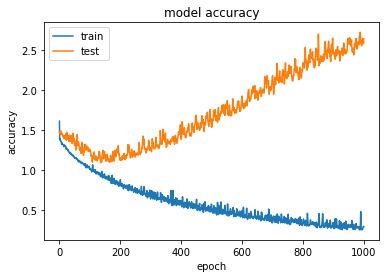

In [1082]:
plt.plot(business_model_2.history['loss'])
plt.plot(business_model_2.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [991]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [1049]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [1050]:
w2v_model_2 = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=400, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/400
2839/2839 [==============================] - 7s 2ms/step - loss: 2.3837 - acc: 0.2740 - val_loss: 2.2945 - val_acc: 0.3353
Epoch 2/400
2839/2839 [==============================] - 0s 61us/step - loss: 2.2386 - acc: 0.3244 - val_loss: 2.2558 - val_acc: 0.3323
Epoch 3/400
2839/2839 [==============================] - 0s 68us/step - loss: 2.1757 - acc: 0.3329 - val_loss: 2.2510 - val_acc: 0.3323
Epoch 4/400
2839/2839 [==============================] - 0s 66us/step - loss: 2.1451 - acc: 0.3286 - val_loss: 2.1958 - val_acc: 0.3323
Epoch 5/400
2839/2839 [==============================] - 0s 70us/step - loss: 2.0881 - acc: 0.3589 - val_loss: 2.1864 - val_acc: 0.3353
Epoch 6/400
2839/2839 [==============================] - 0s 65us/step - loss: 2.0750 - acc: 0.3417 - val_loss: 2.1477 - val_acc: 0.3323
Epoch 7/400
2839/2839 [==============================] - 0s 65us/step - loss: 2.0568 - acc: 0.3603 - val_loss: 2.1203 - val_acc: 0.3353
Ep

Epoch 120/400
2839/2839 [==============================] - 0s 62us/step - loss: 1.3046 - acc: 0.4713 - val_loss: 1.5285 - val_acc: 0.3958
Epoch 121/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.3003 - acc: 0.4565 - val_loss: 1.6226 - val_acc: 0.3293
Epoch 122/400
2839/2839 [==============================] - 0s 63us/step - loss: 1.3089 - acc: 0.4192 - val_loss: 1.6246 - val_acc: 0.3353
Epoch 123/400
2839/2839 [==============================] - 0s 65us/step - loss: 1.2545 - acc: 0.4435 - val_loss: 1.7287 - val_acc: 0.3323
Epoch 124/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.3013 - acc: 0.4364 - val_loss: 1.5000 - val_acc: 0.3625
Epoch 125/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.2517 - acc: 0.4406 - val_loss: 1.4358 - val_acc: 0.4350
Epoch 126/400
2839/2839 [==============================] - 0s 63us/step - loss: 1.3038 - acc: 0.4421 - val_loss: 1.4389 - val_acc: 0.4350
Epoch 127/400
2839/2839 [=========

2839/2839 [==============================] - 0s 64us/step - loss: 1.1645 - acc: 0.4653 - val_loss: 1.5486 - val_acc: 0.3656
Epoch 239/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.1327 - acc: 0.4727 - val_loss: 1.4424 - val_acc: 0.4350
Epoch 240/400
2839/2839 [==============================] - 0s 65us/step - loss: 1.0962 - acc: 0.5178 - val_loss: 1.5915 - val_acc: 0.3686
Epoch 241/400
2839/2839 [==============================] - 0s 63us/step - loss: 1.1941 - acc: 0.4657 - val_loss: 1.4650 - val_acc: 0.4048
Epoch 242/400
2839/2839 [==============================] - 0s 63us/step - loss: 1.1038 - acc: 0.4826 - val_loss: 1.4059 - val_acc: 0.4502
Epoch 243/400
2839/2839 [==============================] - 0s 65us/step - loss: 1.0704 - acc: 0.5213 - val_loss: 1.5137 - val_acc: 0.3927
Epoch 244/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.1411 - acc: 0.4864 - val_loss: 1.6314 - val_acc: 0.3323
Epoch 245/400
2839/2839 [=======================

2839/2839 [==============================] - 0s 76us/step - loss: 1.0288 - acc: 0.5287 - val_loss: 1.4663 - val_acc: 0.4562
Epoch 357/400
2839/2839 [==============================] - 0s 75us/step - loss: 1.0736 - acc: 0.5026 - val_loss: 1.4152 - val_acc: 0.4683
Epoch 358/400
2839/2839 [==============================] - 0s 75us/step - loss: 1.0082 - acc: 0.5329 - val_loss: 1.4627 - val_acc: 0.4381
Epoch 359/400
2839/2839 [==============================] - 0s 74us/step - loss: 0.9954 - acc: 0.5277 - val_loss: 1.4210 - val_acc: 0.4592
Epoch 360/400
2839/2839 [==============================] - 0s 79us/step - loss: 0.9732 - acc: 0.5548 - val_loss: 1.4633 - val_acc: 0.4381
Epoch 361/400
2839/2839 [==============================] - 0s 76us/step - loss: 1.0077 - acc: 0.5481 - val_loss: 1.7632 - val_acc: 0.2870
Epoch 362/400
2839/2839 [==============================] - 0s 79us/step - loss: 1.1877 - acc: 0.4396 - val_loss: 1.5964 - val_acc: 0.3776
Epoch 363/400
2839/2839 [=======================

#### This is the cell where I adjusted the "top_pred_prob" from 10% to 15% of the top predictions. The predictability lowered but hopefully when I run all of the metrics this will differentiate some of them a bit further

In [86]:
w2v_cluster_models = []
df_w2v_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(631,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    w2v_model_2 = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=300, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_w2v)
    loss = w2v_model_2.history['val_loss'][-1]
    acc = w2v_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean = model_metrics(predictions, y_cat_test_w2v)
    df_w2v_analysis.loc[num,'pred_count'] = gain_pred
    df_w2v_analysis.loc[num,'gain_10%'] = gain_true_large
    df_w2v_analysis.loc[num,'gain_3%'] = gain_true
    df_w2v_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_w2v_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_w2v_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_w2v_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_w2v_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_w2v_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_w2v_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_w2v_analysis.loc[num,'loss'] = loss
    df_w2v_analysis.loc[num,'acc'] = acc
    print(num)
df_300_w = df_w2v_analysis
df_w2v_analysis

Train on 2831 samples, validate on 330 samples
Epoch 1/300
2831/2831 [==============================] - 2s 572us/step - loss: 2.9504 - acc: 0.1533 - val_loss: 2.3532 - val_acc: 0.4121
Epoch 2/300
2831/2831 [==============================] - 0s 62us/step - loss: 2.3800 - acc: 0.2889 - val_loss: 2.3306 - val_acc: 0.3242
Epoch 3/300
2831/2831 [==============================] - 0s 66us/step - loss: 2.3207 - acc: 0.3013 - val_loss: 2.3075 - val_acc: 0.3273
Epoch 4/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.2430 - acc: 0.3402 - val_loss: 2.2414 - val_acc: 0.3303
Epoch 5/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.2180 - acc: 0.3373 - val_loss: 2.2399 - val_acc: 0.3242
Epoch 6/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.1744 - acc: 0.3430 - val_loss: 2.2283 - val_acc: 0.3242
Epoch 7/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.1550 - acc: 0.3370 - val_loss: 2.2061 - val_acc: 0.3273


2831/2831 [==============================] - 0s 66us/step - loss: 1.5289 - acc: 0.3999 - val_loss: 1.6588 - val_acc: 0.3030
Epoch 61/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.4844 - acc: 0.3946 - val_loss: 1.6880 - val_acc: 0.2848
Epoch 62/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.4848 - acc: 0.4002 - val_loss: 1.8168 - val_acc: 0.2303
Epoch 63/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.5312 - acc: 0.3289 - val_loss: 1.6927 - val_acc: 0.3182
Epoch 64/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.4643 - acc: 0.4041 - val_loss: 1.6361 - val_acc: 0.3061
Epoch 65/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.4635 - acc: 0.4126 - val_loss: 1.6459 - val_acc: 0.3000
Epoch 66/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.4484 - acc: 0.4097 - val_loss: 1.6293 - val_acc: 0.3000
Epoch 67/300
2831/2831 [==============================

Epoch 120/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2791 - acc: 0.4437 - val_loss: 1.5559 - val_acc: 0.3697
Epoch 121/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.3040 - acc: 0.4468 - val_loss: 1.6377 - val_acc: 0.2939
Epoch 122/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.3088 - acc: 0.4062 - val_loss: 1.5964 - val_acc: 0.3182
Epoch 123/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2730 - acc: 0.4458 - val_loss: 1.7058 - val_acc: 0.3182
Epoch 124/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.3272 - acc: 0.4271 - val_loss: 1.6282 - val_acc: 0.3091
Epoch 125/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.2905 - acc: 0.4196 - val_loss: 1.6998 - val_acc: 0.2697
Epoch 126/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.3074 - acc: 0.3910 - val_loss: 1.5327 - val_acc: 0.3455
Epoch 127/300
2831/2831 [=========

2831/2831 [==============================] - 0s 62us/step - loss: 1.1881 - acc: 0.4596 - val_loss: 1.4500 - val_acc: 0.3606
Epoch 180/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2491 - acc: 0.4585 - val_loss: 1.5452 - val_acc: 0.3606
Epoch 181/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2250 - acc: 0.4564 - val_loss: 1.6031 - val_acc: 0.3121
Epoch 182/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.2320 - acc: 0.4444 - val_loss: 1.5727 - val_acc: 0.3333
Epoch 183/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1909 - acc: 0.4394 - val_loss: 1.5135 - val_acc: 0.3788
Epoch 184/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1587 - acc: 0.4702 - val_loss: 1.5056 - val_acc: 0.4182
Epoch 185/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1752 - acc: 0.4588 - val_loss: 1.4939 - val_acc: 0.4152
Epoch 186/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 62us/step - loss: 1.1233 - acc: 0.4899 - val_loss: 1.5917 - val_acc: 0.3455
Epoch 239/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1769 - acc: 0.4451 - val_loss: 1.4588 - val_acc: 0.3939
Epoch 240/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.1144 - acc: 0.4804 - val_loss: 1.4870 - val_acc: 0.3848
Epoch 241/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.1421 - acc: 0.4871 - val_loss: 1.6309 - val_acc: 0.3091
Epoch 242/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1718 - acc: 0.4430 - val_loss: 1.4437 - val_acc: 0.4030
Epoch 243/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.0953 - acc: 0.5079 - val_loss: 1.5104 - val_acc: 0.3939
Epoch 244/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1417 - acc: 0.4811 - val_loss: 1.5320 - val_acc: 0.3939
Epoch 245/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 61us/step - loss: 1.1444 - acc: 0.4447 - val_loss: 1.5228 - val_acc: 0.3727
Epoch 298/300
2831/2831 [==============================] - 0s 76us/step - loss: 1.1224 - acc: 0.4617 - val_loss: 1.4977 - val_acc: 0.3697
Epoch 299/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0877 - acc: 0.4864 - val_loss: 1.5245 - val_acc: 0.3636
Epoch 300/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1166 - acc: 0.4677 - val_loss: 1.4334 - val_acc: 0.3879
0
Train on 2831 samples, validate on 330 samples
Epoch 1/300
2831/2831 [==============================] - 1s 462us/step - loss: 2.5445 - acc: 0.2176 - val_loss: 2.4234 - val_acc: 0.0818
Epoch 2/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.3086 - acc: 0.2303 - val_loss: 2.3210 - val_acc: 0.3303
Epoch 3/300
2831/2831 [==============================] - 0s 62us/step - loss: 2.1724 - acc: 0.3289 - val_loss: 2.2781 - val_acc: 0.3303
Epoc

2831/2831 [==============================] - 0s 62us/step - loss: 1.5416 - acc: 0.3642 - val_loss: 1.7348 - val_acc: 0.3152
Epoch 57/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.4936 - acc: 0.3999 - val_loss: 1.6528 - val_acc: 0.3182
Epoch 58/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.4623 - acc: 0.4140 - val_loss: 1.6082 - val_acc: 0.3273
Epoch 59/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.4747 - acc: 0.4221 - val_loss: 1.6001 - val_acc: 0.3303
Epoch 60/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.4692 - acc: 0.4256 - val_loss: 1.5965 - val_acc: 0.3273
Epoch 61/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.4711 - acc: 0.4412 - val_loss: 1.6266 - val_acc: 0.3152
Epoch 62/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.4430 - acc: 0.4260 - val_loss: 1.5424 - val_acc: 0.3455
Epoch 63/300
2831/2831 [==============================

Epoch 116/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2761 - acc: 0.4355 - val_loss: 1.4694 - val_acc: 0.3697
Epoch 117/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.2808 - acc: 0.4377 - val_loss: 1.4420 - val_acc: 0.3545
Epoch 118/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.3112 - acc: 0.4412 - val_loss: 1.4955 - val_acc: 0.3576
Epoch 119/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.2602 - acc: 0.4532 - val_loss: 1.4078 - val_acc: 0.3727
Epoch 120/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.3045 - acc: 0.4564 - val_loss: 1.4447 - val_acc: 0.3939
Epoch 121/300
2831/2831 [==============================] - 0s 61us/step - loss: 1.3205 - acc: 0.4588 - val_loss: 1.5343 - val_acc: 0.3515
Epoch 122/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3143 - acc: 0.4348 - val_loss: 1.5457 - val_acc: 0.3515
Epoch 123/300
2831/2831 [=========

2831/2831 [==============================] - 0s 62us/step - loss: 1.2042 - acc: 0.4815 - val_loss: 1.4785 - val_acc: 0.4000
Epoch 176/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2037 - acc: 0.4596 - val_loss: 1.5671 - val_acc: 0.3848
Epoch 177/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1989 - acc: 0.4422 - val_loss: 1.5779 - val_acc: 0.3485
Epoch 178/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2069 - acc: 0.4546 - val_loss: 1.6037 - val_acc: 0.3273
Epoch 179/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2240 - acc: 0.4525 - val_loss: 1.4995 - val_acc: 0.3364
Epoch 180/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1849 - acc: 0.4603 - val_loss: 1.4224 - val_acc: 0.3606
Epoch 181/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1507 - acc: 0.4783 - val_loss: 1.3633 - val_acc: 0.4091
Epoch 182/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 65us/step - loss: 1.1166 - acc: 0.4839 - val_loss: 1.5441 - val_acc: 0.3939
Epoch 235/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1847 - acc: 0.4525 - val_loss: 1.5340 - val_acc: 0.3576
Epoch 236/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.1457 - acc: 0.4670 - val_loss: 1.4627 - val_acc: 0.4030
Epoch 237/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.1234 - acc: 0.4885 - val_loss: 1.4533 - val_acc: 0.3909
Epoch 238/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1152 - acc: 0.4765 - val_loss: 1.4764 - val_acc: 0.3879
Epoch 239/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1514 - acc: 0.4641 - val_loss: 1.5584 - val_acc: 0.3758
Epoch 240/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.1719 - acc: 0.4553 - val_loss: 1.5070 - val_acc: 0.3909
Epoch 241/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 68us/step - loss: 1.1576 - acc: 0.5065 - val_loss: 1.3644 - val_acc: 0.4667
Epoch 294/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0549 - acc: 0.5390 - val_loss: 1.3627 - val_acc: 0.4394
Epoch 295/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.0920 - acc: 0.5083 - val_loss: 1.3700 - val_acc: 0.4424
Epoch 296/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.1336 - acc: 0.5034 - val_loss: 1.3839 - val_acc: 0.4394
Epoch 297/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.0351 - acc: 0.5253 - val_loss: 1.5123 - val_acc: 0.4121
Epoch 298/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1325 - acc: 0.4673 - val_loss: 1.5577 - val_acc: 0.3909
Epoch 299/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1241 - acc: 0.4546 - val_loss: 1.4050 - val_acc: 0.4667
Epoch 300/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 72us/step - loss: 1.4851 - acc: 0.4037 - val_loss: 1.7047 - val_acc: 0.3152
Epoch 53/300
2831/2831 [==============================] - 0s 59us/step - loss: 1.4665 - acc: 0.4161 - val_loss: 1.7199 - val_acc: 0.3182
Epoch 54/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.4824 - acc: 0.4059 - val_loss: 1.6919 - val_acc: 0.3152
Epoch 55/300
2831/2831 [==============================] - 0s 76us/step - loss: 1.4718 - acc: 0.4122 - val_loss: 1.6375 - val_acc: 0.3212
Epoch 56/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.4530 - acc: 0.4221 - val_loss: 1.5994 - val_acc: 0.3242
Epoch 57/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.4684 - acc: 0.4037 - val_loss: 1.5453 - val_acc: 0.3333
Epoch 58/300
2831/2831 [==============================] - 0s 78us/step - loss: 1.4947 - acc: 0.4299 - val_loss: 1.6543 - val_acc: 0.3121
Epoch 59/300
2831/2831 [==============================

Epoch 112/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.3075 - acc: 0.4327 - val_loss: 1.7429 - val_acc: 0.2727
Epoch 113/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.3260 - acc: 0.4094 - val_loss: 1.5699 - val_acc: 0.3030
Epoch 114/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2651 - acc: 0.4348 - val_loss: 1.5772 - val_acc: 0.3030
Epoch 115/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2615 - acc: 0.4398 - val_loss: 1.5776 - val_acc: 0.3061
Epoch 116/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2852 - acc: 0.4246 - val_loss: 1.5068 - val_acc: 0.3273
Epoch 117/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3007 - acc: 0.4419 - val_loss: 1.5477 - val_acc: 0.3242
Epoch 118/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2621 - acc: 0.4398 - val_loss: 1.8103 - val_acc: 0.2545
Epoch 119/300
2831/2831 [=========

2831/2831 [==============================] - 0s 63us/step - loss: 1.1840 - acc: 0.4571 - val_loss: 1.5836 - val_acc: 0.3242
Epoch 172/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2152 - acc: 0.4373 - val_loss: 1.5790 - val_acc: 0.3303
Epoch 173/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2107 - acc: 0.4281 - val_loss: 1.5061 - val_acc: 0.3394
Epoch 174/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2060 - acc: 0.4415 - val_loss: 1.5564 - val_acc: 0.3212
Epoch 175/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2088 - acc: 0.4408 - val_loss: 1.4985 - val_acc: 0.3333
Epoch 176/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1755 - acc: 0.4550 - val_loss: 1.5784 - val_acc: 0.3212
Epoch 177/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2343 - acc: 0.4377 - val_loss: 1.5991 - val_acc: 0.3273
Epoch 178/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 65us/step - loss: 1.1023 - acc: 0.4875 - val_loss: 1.3293 - val_acc: 0.4212
Epoch 231/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2176 - acc: 0.4680 - val_loss: 1.3452 - val_acc: 0.4000
Epoch 232/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1385 - acc: 0.4938 - val_loss: 1.3783 - val_acc: 0.3848
Epoch 233/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1140 - acc: 0.4758 - val_loss: 1.3709 - val_acc: 0.4000
Epoch 234/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2074 - acc: 0.4807 - val_loss: 1.3648 - val_acc: 0.4152
Epoch 235/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0963 - acc: 0.4956 - val_loss: 1.3741 - val_acc: 0.4182
Epoch 236/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0825 - acc: 0.4998 - val_loss: 1.4010 - val_acc: 0.4242
Epoch 237/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 63us/step - loss: 1.0760 - acc: 0.4928 - val_loss: 1.3508 - val_acc: 0.4485
Epoch 290/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0635 - acc: 0.5108 - val_loss: 1.3876 - val_acc: 0.4394
Epoch 291/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0734 - acc: 0.5048 - val_loss: 1.5425 - val_acc: 0.3667
Epoch 292/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1729 - acc: 0.4574 - val_loss: 1.4598 - val_acc: 0.3697
Epoch 293/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0849 - acc: 0.4917 - val_loss: 1.3956 - val_acc: 0.3970
Epoch 294/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0340 - acc: 0.5221 - val_loss: 1.4323 - val_acc: 0.3970
Epoch 295/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.0936 - acc: 0.5005 - val_loss: 1.7424 - val_acc: 0.2788
Epoch 296/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 63us/step - loss: 1.5796 - acc: 0.3995 - val_loss: 1.8095 - val_acc: 0.3152
Epoch 49/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5551 - acc: 0.4087 - val_loss: 1.7704 - val_acc: 0.3242
Epoch 50/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.5535 - acc: 0.4037 - val_loss: 1.8771 - val_acc: 0.2788
Epoch 51/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5851 - acc: 0.3698 - val_loss: 1.7564 - val_acc: 0.3515
Epoch 52/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.5659 - acc: 0.4189 - val_loss: 1.6759 - val_acc: 0.3576
Epoch 53/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.5467 - acc: 0.4115 - val_loss: 1.6742 - val_acc: 0.3485
Epoch 54/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.5245 - acc: 0.4288 - val_loss: 1.6843 - val_acc: 0.3515
Epoch 55/300
2831/2831 [==============================

Epoch 108/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3290 - acc: 0.4207 - val_loss: 1.6899 - val_acc: 0.2879
Epoch 109/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.3715 - acc: 0.3826 - val_loss: 1.5993 - val_acc: 0.3303
Epoch 110/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3259 - acc: 0.4334 - val_loss: 1.5458 - val_acc: 0.4030
Epoch 111/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3441 - acc: 0.4483 - val_loss: 1.4912 - val_acc: 0.4000
Epoch 112/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.3366 - acc: 0.4521 - val_loss: 1.4481 - val_acc: 0.3606
Epoch 113/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.3405 - acc: 0.4525 - val_loss: 1.4864 - val_acc: 0.3818
Epoch 114/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.2958 - acc: 0.4610 - val_loss: 1.4879 - val_acc: 0.3909
Epoch 115/300
2831/2831 [=========

2831/2831 [==============================] - 0s 63us/step - loss: 1.3075 - acc: 0.4101 - val_loss: 1.4656 - val_acc: 0.3697
Epoch 168/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2165 - acc: 0.4627 - val_loss: 1.4704 - val_acc: 0.3818
Epoch 169/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2141 - acc: 0.4815 - val_loss: 1.5566 - val_acc: 0.3576
Epoch 170/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2349 - acc: 0.4744 - val_loss: 1.5898 - val_acc: 0.3303
Epoch 171/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2581 - acc: 0.4264 - val_loss: 1.6005 - val_acc: 0.3061
Epoch 172/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2388 - acc: 0.4267 - val_loss: 1.4974 - val_acc: 0.4000
Epoch 173/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2047 - acc: 0.4673 - val_loss: 1.4521 - val_acc: 0.4273
Epoch 174/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 73us/step - loss: 1.1404 - acc: 0.4832 - val_loss: 1.6094 - val_acc: 0.3606
Epoch 227/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.2089 - acc: 0.4387 - val_loss: 1.3875 - val_acc: 0.4515
Epoch 228/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.1256 - acc: 0.5200 - val_loss: 1.3964 - val_acc: 0.4455
Epoch 229/300
2831/2831 [==============================] - 0s 75us/step - loss: 1.1488 - acc: 0.5132 - val_loss: 1.3539 - val_acc: 0.4788
Epoch 230/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.2037 - acc: 0.4790 - val_loss: 1.3372 - val_acc: 0.4182
Epoch 231/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.1799 - acc: 0.4702 - val_loss: 1.3492 - val_acc: 0.4515
Epoch 232/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.1151 - acc: 0.5147 - val_loss: 1.3727 - val_acc: 0.4606
Epoch 233/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 60us/step - loss: 1.1309 - acc: 0.4744 - val_loss: 1.5318 - val_acc: 0.4091
Epoch 286/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1132 - acc: 0.4864 - val_loss: 1.3648 - val_acc: 0.4273
Epoch 287/300
2831/2831 [==============================] - 0s 77us/step - loss: 1.0441 - acc: 0.5341 - val_loss: 1.3835 - val_acc: 0.4667
Epoch 288/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.0407 - acc: 0.5429 - val_loss: 1.5221 - val_acc: 0.3848
Epoch 289/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1690 - acc: 0.4691 - val_loss: 1.4445 - val_acc: 0.3879
Epoch 290/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.0912 - acc: 0.5009 - val_loss: 1.3757 - val_acc: 0.4333
Epoch 291/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.0849 - acc: 0.5037 - val_loss: 1.3694 - val_acc: 0.4576
Epoch 292/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 71us/step - loss: 1.5862 - acc: 0.4002 - val_loss: 1.7798 - val_acc: 0.3121
Epoch 45/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.5839 - acc: 0.3737 - val_loss: 1.9107 - val_acc: 0.2970
Epoch 46/300
2831/2831 [==============================] - 0s 60us/step - loss: 1.5752 - acc: 0.3674 - val_loss: 1.7839 - val_acc: 0.3152
Epoch 47/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5509 - acc: 0.4143 - val_loss: 1.8086 - val_acc: 0.3121
Epoch 48/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.5410 - acc: 0.4062 - val_loss: 1.7846 - val_acc: 0.3091
Epoch 49/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.5466 - acc: 0.3974 - val_loss: 1.9239 - val_acc: 0.3152
Epoch 50/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5705 - acc: 0.3931 - val_loss: 1.8285 - val_acc: 0.3121
Epoch 51/300
2831/2831 [==============================

Epoch 104/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.3383 - acc: 0.4430 - val_loss: 1.7867 - val_acc: 0.2636
Epoch 105/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.3333 - acc: 0.4129 - val_loss: 1.6755 - val_acc: 0.2939
Epoch 106/300
2831/2831 [==============================] - 0s 75us/step - loss: 1.3154 - acc: 0.4147 - val_loss: 1.6271 - val_acc: 0.3303
Epoch 107/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.3094 - acc: 0.4362 - val_loss: 1.6907 - val_acc: 0.3000
Epoch 108/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.3169 - acc: 0.4239 - val_loss: 1.7101 - val_acc: 0.2909
Epoch 109/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.3265 - acc: 0.4175 - val_loss: 1.6834 - val_acc: 0.3394
Epoch 110/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.3010 - acc: 0.4535 - val_loss: 1.8691 - val_acc: 0.2879
Epoch 111/300
2831/2831 [=========

2831/2831 [==============================] - 0s 65us/step - loss: 1.2142 - acc: 0.4624 - val_loss: 1.5906 - val_acc: 0.3636
Epoch 164/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.2387 - acc: 0.4507 - val_loss: 1.7562 - val_acc: 0.3303
Epoch 165/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2772 - acc: 0.4408 - val_loss: 1.5316 - val_acc: 0.3727
Epoch 166/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.2159 - acc: 0.4571 - val_loss: 1.4697 - val_acc: 0.4061
Epoch 167/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1771 - acc: 0.4839 - val_loss: 1.4576 - val_acc: 0.4212
Epoch 168/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1777 - acc: 0.4921 - val_loss: 1.5145 - val_acc: 0.3970
Epoch 169/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2227 - acc: 0.4652 - val_loss: 1.8003 - val_acc: 0.2939
Epoch 170/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 65us/step - loss: 1.1429 - acc: 0.4949 - val_loss: 1.4045 - val_acc: 0.4545
Epoch 223/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1707 - acc: 0.5005 - val_loss: 1.4384 - val_acc: 0.4545
Epoch 224/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1320 - acc: 0.4970 - val_loss: 1.3957 - val_acc: 0.4424
Epoch 225/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1132 - acc: 0.4942 - val_loss: 1.3564 - val_acc: 0.4576
Epoch 226/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1728 - acc: 0.4917 - val_loss: 1.2888 - val_acc: 0.4939
Epoch 227/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2507 - acc: 0.4935 - val_loss: 1.4485 - val_acc: 0.4303
Epoch 228/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1247 - acc: 0.4815 - val_loss: 1.3908 - val_acc: 0.4424
Epoch 229/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 76us/step - loss: 1.1108 - acc: 0.4776 - val_loss: 1.5629 - val_acc: 0.3970
Epoch 282/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.1134 - acc: 0.4815 - val_loss: 1.5025 - val_acc: 0.3970
Epoch 283/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.0923 - acc: 0.4928 - val_loss: 1.5788 - val_acc: 0.3727
Epoch 284/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.1404 - acc: 0.4793 - val_loss: 1.4452 - val_acc: 0.4212
Epoch 285/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.1110 - acc: 0.4949 - val_loss: 1.4184 - val_acc: 0.4485
Epoch 286/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.0853 - acc: 0.5076 - val_loss: 1.5361 - val_acc: 0.3758
Epoch 287/300
2831/2831 [==============================] - 0s 75us/step - loss: 1.1376 - acc: 0.4786 - val_loss: 1.5547 - val_acc: 0.3970
Epoch 288/300
2831/2831 [=======================

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,176.0,0.090909,0.585227,0.931818,0.22,0.80,0.96,0.055814,0.427907,0.860465,1.433414,0.387879
1,208.0,0.081731,0.519231,0.894231,0.24,0.82,0.98,0.057851,0.442149,0.855372,1.581616,0.390909
2,77.0,0.181818,0.701299,0.948052,0.26,0.82,0.96,0.071429,0.482143,0.869048,1.316483,0.451515
3,185.0,0.086486,0.567568,0.929730,0.22,0.82,0.96,0.057269,0.444934,0.845815,1.453355,0.393939
4,164.0,0.091463,0.603659,0.920732,0.24,0.80,0.96,0.077670,0.466019,0.844660,1.495068,0.396970


In [1121]:
df_400_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,87.0,0.094972,0.758621,0.977011,0.303030,0.848485,0.939394,0.087302,0.539683,0.904762,1.414496,0.432024
1,137.0,0.094972,0.671533,0.948905,0.303030,0.848485,0.939394,0.069519,0.491979,0.866310,1.475380,0.416918
2,54.0,0.094972,0.777778,0.962963,0.242424,0.818182,0.939394,0.069565,0.539130,0.886957,1.399635,0.459215
3,100.0,0.094972,0.720000,0.960000,0.272727,0.787879,0.939394,0.086331,0.496403,0.848921,1.491990,0.438066
4,111.0,0.094972,0.684685,0.945946,0.303030,0.787879,0.939394,0.072993,0.481752,0.854015,1.385046,0.471299


In [1119]:
# Without weights, 400 epochs
df_400

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,52.0,0.094972,0.788462,0.961538,0.272727,0.848485,0.969697,0.090164,0.557377,0.877049,1.543366,0.450151
1,45.0,0.094972,0.755556,0.955556,0.272727,0.787879,0.939394,0.095652,0.486957,0.878261,1.527017,0.456193
2,44.0,0.094972,0.772727,0.954545,0.272727,0.757576,0.939394,0.105263,0.526316,0.921053,1.605956,0.456193
3,47.0,0.094972,0.872340,0.978723,0.242424,0.787879,0.969697,0.064103,0.615385,0.923077,1.634043,0.444109
4,70.0,0.094972,0.771429,0.971429,0.212121,0.787879,0.969697,0.085714,0.528571,0.878571,1.477137,0.471299


In [1133]:
# Best
df_300_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,223.0,0.094972,0.502242,0.878924,0.333333,0.878788,0.969697,0.057034,0.418251,0.851711,1.546759,0.410876
1,110.0,0.094972,0.690909,0.963636,0.272727,0.818182,0.939394,0.095588,0.485294,0.845588,1.335251,0.483384
2,73.0,0.094972,0.726027,0.945205,0.333333,0.848485,0.939394,0.100917,0.559633,0.889908,1.317518,0.462236
3,93.0,0.094972,0.731183,0.935484,0.242424,0.787879,0.939394,0.086614,0.496063,0.842520,1.512711,0.422961
4,54.0,0.094972,0.833333,0.962963,0.303030,0.848485,0.939394,0.095890,0.527397,0.897260,1.338329,0.432024


In [1129]:
df_300

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.672566,0.929204,0.303030,0.787879,0.939394,0.083832,0.491018,0.880240,1.431859,0.410876
1,46.0,0.094972,0.760870,0.956522,0.272727,0.787879,0.969697,0.131579,0.491228,0.842105,1.336695,0.474320
2,73.0,0.094972,0.753425,0.958904,0.272727,0.757576,0.939394,0.093458,0.532710,0.897196,1.354104,0.465257
3,51.0,0.094972,0.784314,0.960784,0.242424,0.848485,0.939394,0.075145,0.450867,0.838150,1.313191,0.444109
4,75.0,0.094972,0.733333,0.946667,0.272727,0.787879,0.969697,0.065476,0.488095,0.851190,1.275235,0.471299


In [1131]:
# Without weights, 225 epochs
df_225

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,85.0,0.094972,0.705882,0.941176,0.242424,0.757576,0.939394,0.081522,0.434783,0.847826,1.230999,0.447130
1,123.0,0.094972,0.674797,0.934959,0.272727,0.727273,0.939394,0.086294,0.477157,0.832487,1.229504,0.447130
2,112.0,0.094972,0.678571,0.928571,0.272727,0.848485,0.969697,0.064220,0.440367,0.857798,1.281605,0.398792
3,61.0,0.094972,0.819672,0.967213,0.242424,0.787879,0.939394,0.092308,0.507692,0.846154,1.268600,0.416918
4,60.0,0.094972,0.783333,0.966667,0.272727,0.757576,0.939394,0.090909,0.484848,0.863636,1.282214,0.456193


In [1123]:
# Weights, 225 epochs
df_225_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,191.0,0.094972,0.570681,0.926702,0.272727,0.757576,0.909091,0.088372,0.488372,0.879070,1.429407,0.410876
1,71.0,0.094972,0.732394,0.957746,0.303030,0.818182,0.939394,0.071429,0.428571,0.842857,1.344073,0.471299
2,59.0,0.094972,0.796610,0.966102,0.303030,0.818182,0.939394,0.125000,0.556818,0.840909,1.387137,0.429003
3,119.0,0.094972,0.663866,0.941176,0.303030,0.818182,0.969697,0.083916,0.496503,0.860140,1.544066,0.380665
4,142.0,0.094972,0.640845,0.929577,0.272727,0.787879,0.969697,0.078125,0.447917,0.843750,1.357028,0.465257


In [1127]:
df_175

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,128.0,0.094972,0.664062,0.937500,0.242424,0.757576,0.939394,0.061404,0.421053,0.850877,1.198510,0.407855
1,154.0,0.094972,0.597403,0.909091,0.272727,0.727273,0.939394,0.068293,0.448780,0.863415,1.237291,0.429003
2,249.0,0.094972,0.469880,0.867470,0.303030,0.787879,0.969697,0.066176,0.408088,0.845588,1.319757,0.386707
3,183.0,0.094972,0.584699,0.923497,0.242424,0.818182,0.969697,0.073733,0.433180,0.843318,1.329758,0.371601
4,208.0,0.094972,0.524038,0.913462,0.272727,0.757576,0.909091,0.065041,0.439024,0.833333,1.331992,0.419940


In [1125]:
df_175_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,62.0,0.094972,0.741935,0.951613,0.272727,0.848485,0.969697,0.059113,0.394089,0.832512,1.342970,0.456193
1,179.0,0.094972,0.569832,0.927374,0.272727,0.727273,0.939394,0.063348,0.434389,0.837104,1.422866,0.432024
2,186.0,0.094972,0.575269,0.930108,0.272727,0.727273,0.878788,0.073913,0.426087,0.843478,1.432149,0.404834
3,271.0,0.094972,0.435424,0.837638,0.272727,0.818182,0.969697,0.060403,0.402685,0.828859,1.555367,0.344411
4,211.0,0.094972,0.530806,0.914692,0.272727,0.818182,0.969697,0.082251,0.471861,0.852814,1.608255,0.350453


In [1051]:
predictions = model.predict(X_test_w2v)
#
model_metrics(predictions, y_cat_test_w2v)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test_w2v.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

42
0.8571428571428571
0.9523809523809523
21
0.7142857142857143
0.8571428571428571
0.8181818181818182
0.23809523809523808


array([[ 0,  3,  1,  0,  0],
       [ 4, 39, 66, 23,  5],
       [ 1,  7, 61, 38,  2],
       [ 0,  1, 14, 48,  9],
       [ 0,  2,  2,  1,  4]])

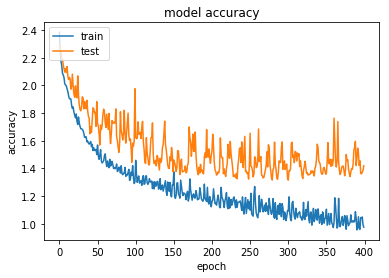

In [1053]:
plt.plot(w2v_model_2.history['loss'])
plt.plot(w2v_model_2.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

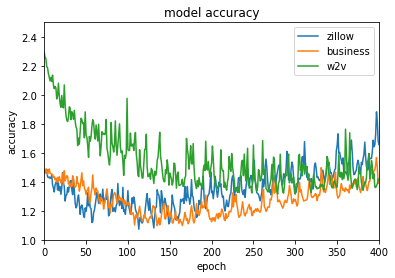

In [1087]:
plt.plot(zillow_model_2.history['val_loss'])
plt.plot(business_model_2.history['val_loss'])
plt.plot(w2v_model_2.history['val_loss'])
plt.title('model accuracy')
plt.xlim(0, 400)
plt.ylim(1, 2.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['zillow', 'business', 'w2v'], loc='upper right')
plt.show()

In [1078]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.000005)))
model.add(Dropout(.1))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [1079]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=400, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/400
2839/2839 [==============================] - 7s 3ms/step - loss: 2.2779 - acc: 0.3209 - val_loss: 2.0955 - val_acc: 0.4350
Epoch 2/400
2839/2839 [==============================] - 0s 63us/step - loss: 2.0493 - acc: 0.3639 - val_loss: 1.9858 - val_acc: 0.3323
Epoch 3/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.9301 - acc: 0.3656 - val_loss: 1.9579 - val_acc: 0.3323
Epoch 4/400
2839/2839 [==============================] - 0s 69us/step - loss: 1.8248 - acc: 0.3706 - val_loss: 1.8833 - val_acc: 0.3323
Epoch 5/400
2839/2839 [==============================] - 0s 69us/step - loss: 1.7600 - acc: 0.3695 - val_loss: 1.8576 - val_acc: 0.3323
Epoch 6/400
2839/2839 [==============================] - 0s 69us/step - loss: 1.7005 - acc: 0.3706 - val_loss: 1.8073 - val_acc: 0.3323
Epoch 7/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.6577 - acc: 0.3677 - val_loss: 1.7993 - val_acc: 0.3323
Ep

Epoch 120/400
2839/2839 [==============================] - 0s 64us/step - loss: 1.2208 - acc: 0.4030 - val_loss: 1.3995 - val_acc: 0.3172
Epoch 121/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.2213 - acc: 0.4089 - val_loss: 1.4711 - val_acc: 0.2719
Epoch 122/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.2466 - acc: 0.3853 - val_loss: 1.4465 - val_acc: 0.2840
Epoch 123/400
2839/2839 [==============================] - 0s 69us/step - loss: 1.2147 - acc: 0.3853 - val_loss: 1.4343 - val_acc: 0.2931
Epoch 124/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.1943 - acc: 0.4023 - val_loss: 1.4449 - val_acc: 0.2689
Epoch 125/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.2005 - acc: 0.3818 - val_loss: 1.6182 - val_acc: 0.1722
Epoch 126/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.2619 - acc: 0.2871 - val_loss: 1.3902 - val_acc: 0.3233
Epoch 127/400
2839/2839 [=========

2839/2839 [==============================] - 0s 68us/step - loss: 1.0996 - acc: 0.4329 - val_loss: 1.5903 - val_acc: 0.3233
Epoch 239/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.1116 - acc: 0.4065 - val_loss: 1.3445 - val_acc: 0.3776
Epoch 240/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.0402 - acc: 0.4519 - val_loss: 1.3045 - val_acc: 0.3897
Epoch 241/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.0598 - acc: 0.4329 - val_loss: 1.2538 - val_acc: 0.3686
Epoch 242/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.1617 - acc: 0.4283 - val_loss: 1.3395 - val_acc: 0.3927
Epoch 243/400
2839/2839 [==============================] - 0s 66us/step - loss: 1.0391 - acc: 0.4621 - val_loss: 1.3051 - val_acc: 0.3837
Epoch 244/400
2839/2839 [==============================] - 0s 67us/step - loss: 1.1019 - acc: 0.4438 - val_loss: 1.2923 - val_acc: 0.3807
Epoch 245/400
2839/2839 [=======================

Epoch 297/400
2839/2839 [==============================] - 0s 69us/step - loss: 1.0127 - acc: 0.4727 - val_loss: 1.2372 - val_acc: 0.4411
Epoch 298/400
2839/2839 [==============================] - 0s 82us/step - loss: 1.0248 - acc: 0.4783 - val_loss: 1.2470 - val_acc: 0.4441
Epoch 299/400
2839/2839 [==============================] - 0s 74us/step - loss: 1.0148 - acc: 0.4783 - val_loss: 1.3682 - val_acc: 0.3927
Epoch 300/400
2839/2839 [==============================] - 0s 65us/step - loss: 1.0706 - acc: 0.4579 - val_loss: 1.3652 - val_acc: 0.3746
Epoch 301/400
2839/2839 [==============================] - 0s 68us/step - loss: 1.0169 - acc: 0.4540 - val_loss: 1.3153 - val_acc: 0.4199
Epoch 302/400
2839/2839 [==============================] - 0s 68us/step - loss: 0.9808 - acc: 0.4836 - val_loss: 1.2939 - val_acc: 0.4411
Epoch 303/400
2839/2839 [==============================] - 0s 68us/step - loss: 0.9713 - acc: 0.4731 - val_loss: 1.2486 - val_acc: 0.4502
Epoch 304/400
2839/2839 [=========

In [1080]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, y_cat_test_w2v)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_cat_test_w2v.values.argmax(axis=1)
matrix = confusion_matrix(predicted_classes, true_classes)
matrix

105
0.6761904761904762
0.9619047619047619
43
0.6046511627906976
0.9302325581395349
0.7575757575757576
0.13333333333333333


array([[ 0,  4,  1,  1,  0],
       [ 4, 35, 48, 19,  3],
       [ 0,  4, 27,  5,  0],
       [ 1,  6, 61, 82, 16],
       [ 0,  3,  7,  3,  1]])

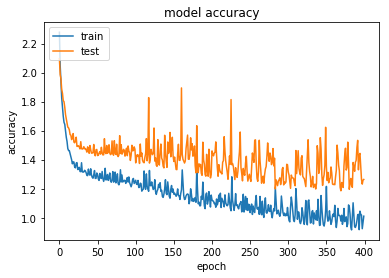

In [1081]:
plt.plot(w2v_model.history['loss'])
plt.plot(w2v_model.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()